## Initial Data Formation.

#### Import basic Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from time import time

#### Import Additional Modules

In [2]:
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import os
import tempfile
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from statistics import mean, stdev
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow import keras

/Users/suchith/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


#### Read the Data into Dataframes.

In [3]:
user_log = pd.read_csv('user_log.csv', iterator=True, chunksize=10000)
user_log = pd.concat(user_log, ignore_index=True)

In [4]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [5]:
user_info = pd.read_csv('user_info.csv', iterator=True, chunksize=10000)
user_info = pd.concat(user_info, ignore_index=True)

In [6]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


#### Check for Missing Values

In [7]:
user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id        True
time_stamp     False
action_type    False
dtype: bool

In [8]:
user_info.isnull().any()

user_id      False
age_range     True
gender        True
dtype: bool

#### Define User Action

In [9]:
user_action = user_log.groupby('user_id').size().to_frame().reset_index()
user_action.columns = ['user_id','user_total_action']

In [10]:
user_action.head()

,user_id,user_total_action
0,1,33
1,2,63
2,3,68
3,4,50
4,5,173


#### Fill Gender Missing Values

In [11]:
user_gender = user_info[['user_id','gender']]
user_gender = user_gender.fillna(2)

In [12]:
user_gender.head()

,user_id,gender
0,376517,1.0
1,234512,0.0
2,344532,0.0
3,186135,0.0
4,30230,0.0


#### Divide the genders into diff. Classes

In [13]:
user_gender_info = label_binarize(np.array(user_gender.gender), classes=[0,1,2])
user_gender_info = pd.DataFrame(data=user_gender_info, columns=['gender_female','gender_male','gender_unknown'])

#### Add the gender as different Columns

In [14]:
user_gender['user_gender_female']=user_gender_info['gender_female']
user_gender['user_gender_male']=user_gender_info['gender_male']
user_gender['user_gender_unknown']=user_gender_info['gender_unknown']

#### Drop Gender Column from the Data

In [15]:
user_gender = user_gender.drop(columns = ['gender'])

In [16]:
user_gender.head()

,user_id,user_gender_female,user_gender_male,user_gender_unknown
0,376517,0,1,0
1,234512,1,0,0
2,344532,1,0,0
3,186135,1,0,0
4,30230,1,0,0


#### Define Action types of an User

#### Label the Action Type of an User

In [17]:
user_activity = user_log[['user_id','action_type']].copy()
user_activity_info = label_binarize(np.array(user_activity.action_type), classes=[0,1,2,3])
user_activity_info = pd.DataFrame(data = user_activity_info, columns=['Click','add_to_cart','purchase','add_to_favorite'])

#### Add Action Types as different Columns to the Data.

In [18]:
user_activity['user_Click']= user_activity_info.Click
user_activity['user_Add_to_cart']=user_activity_info.add_to_cart
user_activity['user_purchase']=user_activity_info.purchase
user_activity['user_Add_to_favorite']=user_activity_info.add_to_favorite

In [19]:
user_activity.head()

,user_id,action_type,user_Click,user_Add_to_cart,user_purchase,user_Add_to_favorite
0,328862,0,1,0,0,0
1,328862,0,1,0,0,0
2,328862,0,1,0,0,0
3,328862,0,1,0,0,0
4,328862,0,1,0,0,0


#### Calculate the number of times an User performed a specific action.

In [20]:
user_activity_count = user_activity.groupby('user_id').agg('sum').reset_index()
user_activity_count.columns = ['user_id','action_type','user_Click_Count','user_Add_to_cart_count','user_purchase_count','user_Add_to_favorite_count']

#### Drop action_type Column from the data.

In [21]:
user_activity_count = user_activity_count.drop(columns=['action_type'])

In [22]:
user_activity_count.head()

,user_id,user_Click_Count,user_Add_to_cart_count,user_purchase_count,user_Add_to_favorite_count
0,1,27,0,6,0
1,2,47,0,14,2
2,3,63,0,4,1
3,4,49,0,1,0
4,5,150,0,13,10


#### Define Age groups of Users.

In [23]:
user_age = user_info[['user_id','age_range']].copy()
user_age = user_age.fillna(9)
user_age = user_age.replace(8,7)
user_age = user_age.drop_duplicates()

#### Label the Age Group of an User.

In [24]:
user_age_info = label_binarize(np.array(user_age.age_range),classes=[1,2,3,4,5,6,7,9])
user_age_info = pd.DataFrame(data= user_age_info, columns = ['age_0_18','age_18_24','age_25_29','age_30_34','age_35_39','age_40_49','age_50_','age_unknown'])

#### Add Age_Group as Columns to the Data.

In [25]:
user_age['user_age_0_18']=user_age_info['age_0_18']
user_age['user_age_18_24']=user_age_info['age_18_24']
user_age['user_age_25_29']=user_age_info['age_25_29']
user_age['user_age_30_34']=user_age_info['age_30_34']
user_age['user_age_35_39']=user_age_info['age_35_39']
user_age['user_age_40_49']=user_age_info['age_40_49']
user_age['user_age_50_']=user_age_info['age_50_']
user_age['user_age_unknown']=user_age_info['age_unknown']

#### Drop Age Column from the data.

In [26]:
user_age = user_age.drop(columns=['age_range'])

In [27]:
user_age.head()

,user_id,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,user_age_35_39,user_age_40_49,user_age_50_,user_age_unknown
0,376517,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,234512,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,344532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,186135,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,30230,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Define No. of Active days of an User.

In [28]:
user_active_days = user_log[['user_id','time_stamp']].drop_duplicates()

#### Label the Active days of an User.

In [29]:
user_active_days_info = user_active_days.groupby('user_id').size().reset_index()
user_active_days_info.columns = ['user_id','user_active_days']

In [30]:
user_active_days_info.head()

,user_id,user_active_days
0,1,5
1,2,9
2,3,13
3,4,10
4,5,30


#### Define active users by month

In [31]:
user_active_days_2 = user_active_days
user_active_days_2['Day']=user_active_days_2['time_stamp']%100
user_active_days_2['Month']=((user_active_days_2['time_stamp']-user_active_days_2['Day'])/100).astype('int')

#### Label Active Months

In [32]:
user_active_days_2_info = label_binarize(np.array(user_active_days_2.Month),classes=[5,6,7,8,9,10,11])
user_active_days_2_info = pd.DataFrame(data = user_active_days_2_info, columns=['May','June','July','Aug','Sept','Oct','Nov'])

#### Add Months as Columns to the data.

In [33]:
user_active_days_2['May'] = user_active_days_2_info.May
user_active_days_2['June']= user_active_days_2_info.June
user_active_days_2['July']=user_active_days_2_info.July
user_active_days_2['Aug']=user_active_days_2_info.Aug
user_active_days_2['Sept']= user_active_days_2_info.Sept
user_active_days_2['Oct']= user_active_days_2_info.Oct
user_active_days_2['Nov']=user_active_days_2_info.Nov
user_active_Month_counts = user_active_days_2.groupby('user_id').agg('sum').reset_index()
user_active_Month_counts = user_active_Month_counts.drop(columns = ['time_stamp','Day','Month'])
user_active_Month_counts.columns = ['user_id', 'user_May_active_days','user_June_active_days','user_July_active_days','user_Aug_active_days','user_Sept_active_days','user_Oct_active_days','user_Nov_active_days']

In [34]:
user_active_Month_counts.head()

,user_id,user_May_active_days,user_June_active_days,user_July_active_days,user_Aug_active_days,user_Sept_active_days,user_Oct_active_days,user_Nov_active_days
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Define Seller Info.

#### Get the Count of items a Seller had.

In [35]:
seller_item = user_log[['seller_id','item_id']].copy()
seller_item.drop_duplicates(['item_id'], inplace=True)
seller_item_info = seller_item.groupby('seller_id').size().reset_index()
seller_item_info.columns = ['seller_id','seller_item_count']

In [36]:
seller_item_info.head()

,seller_id,seller_item_count
0,1,2977
1,2,154
2,3,171
3,4,155
4,5,660


#### Get Seller Brand Count.

In [37]:
seller_brand = user_log[['seller_id','brand_id']].copy()
seller_brand.drop_duplicates(['brand_id'], inplace=True)
seller_brand_info = seller_brand.groupby('seller_id').size().reset_index()
seller_brand_info.columns = ['seller_id','seller_brand_count']

In [38]:
seller_brand_info.head()

,seller_id,seller_brand_count
0,1,2
1,3,1
2,4,1
3,5,1
4,6,1


#### Get Seller Category Count.

In [39]:
seller_cat = user_log[['seller_id','cat_id']].copy()
seller_cat.drop_duplicates(['cat_id'], inplace=True)
seller_cat_info = seller_cat.groupby('seller_id').size().reset_index()
seller_cat_info.columns = ['seller_id','seller_category_count']

In [40]:
seller_cat_info.head()

,seller_id,seller_category_count
0,1,1
1,15,1
2,16,1
3,19,1
4,21,1


#### Get User Purchase Item Count.

In [41]:
user_item = user_log[['user_id','item_id']].copy()
user_item.drop_duplicates(['item_id'],inplace=True)
user_item_info = user_item.groupby('user_id').size().reset_index()
user_item_info.columns = ['user_id','user_item_count']

In [42]:
user_item_info.head()

,user_id,user_item_count
0,5,2
1,6,3
2,9,1
3,10,1
4,14,2


#### Get User Purchase Category Count.

In [43]:
user_cat = user_log[['user_id','cat_id']].copy()
user_cat.drop_duplicates(['cat_id'],inplace=True)
user_cat_info = user_cat.groupby('user_id').size().reset_index()
user_cat_info.columns = ['user_id','user_category_count']

In [44]:
user_cat_info.head()

,user_id,user_category_count
0,16,2
1,19,2
2,62,1
3,941,1
4,1920,1


#### Get User Purchase Brand Count.

In [45]:
user_brand = user_log[['user_id','brand_id']].copy()
user_brand.drop_duplicates(['brand_id'],inplace=True)
user_brand_info = user_cat.groupby('user_id').size().reset_index()
user_brand_info.columns = ['user_id','user_brand_count']

In [46]:
user_brand_info.head()

,user_id,user_brand_count
0,16,2
1,19,2
2,62,1
3,941,1
4,1920,1


#### Get User Purchase Brand_Category Count.

In [47]:
brand_cat = user_log[['brand_id','cat_id']].copy()
brand_cat.drop_duplicates(['brand_id','cat_id'], inplace=True)
brand_cat_info = brand_cat.groupby('brand_id').size().reset_index()
brand_cat_info.columns = ['brand_id','brand_category_count']

In [48]:
brand_cat_info.head()

,brand_id,brand_category_count
0,1.0,17
1,2.0,1
2,3.0,1
3,4.0,1
4,5.0,11


#### Get User Purchase Category_Item Count.

In [49]:
cat_item = user_log[['cat_id','item_id']].copy()
cat_item.drop_duplicates(['cat_id','item_id'], inplace=True)
cat_item_info = cat_item.groupby('cat_id').size().reset_index()
cat_item_info.columns = ['cat_id','category_item_count']

In [50]:
cat_item_info.head()

,cat_id,category_item_count
0,1,34
1,2,2303
2,3,12
3,4,552
4,5,551


#### Define User, Seller Action Details.

#### Label User Seller and Action.

In [51]:
user_seller_item = user_log[['user_id','seller_id','action_type']].copy()
user_seller_item_info = label_binarize(np.array(user_seller_item.action_type),classes=[0,1,2,3])

#### Add Labels as different Columns to the Data.

In [52]:
user_seller_item_info = pd.DataFrame(data= user_seller_item_info, columns=['Click','Add_to_cart','Purchase','Add_to_favorite'])
user_seller_item['user_seller_Click_count']= user_seller_item_info.Click
user_seller_item['user_seller_Add_to_cart_count']=user_seller_item_info.Add_to_cart
user_seller_item['user_seller_Purchase_count']=user_seller_item_info.Purchase
user_seller_item['user_seller_Add_to_favorite_count']=user_seller_item_info.Add_to_favorite
user_seller_item_act_count = user_seller_item.groupby(['user_id','seller_id']).agg('sum').reset_index()

#### Drop Action Column from the Data.

In [53]:
user_seller_item_act_count = user_seller_item_act_count.drop(columns = ['action_type'])

In [54]:
user_seller_item_act_count.head()

,user_id,seller_id,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count
0,1,471,1,0,0,0
1,1,739,1,0,0,0
2,1,925,3,0,1,0
3,1,1019,10,0,4,0
4,1,1156,1,0,0,0


#### Get Active Days of an User for a Seller.

In [55]:
user_seller_days = user_log[['user_id','seller_id','time_stamp']].copy()
user_seller_days.drop_duplicates(inplace=True)
user_seller_days = user_seller_days.groupby(['user_id','seller_id']).size().reset_index()
user_seller_days.columns = ['user_id','seller_id','user_seller_active_days']

In [56]:
user_seller_days.head()

,user_id,seller_id,user_seller_active_days
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### Get Active Days of an User for a seller monthwise.

In [57]:
user_seller_active_days = user_log[['user_id','seller_id','time_stamp']].copy().drop_duplicates()
user_seller_active_days['Day']=user_seller_active_days['time_stamp']%100
user_seller_active_days['Month']=((user_seller_active_days['time_stamp']-user_seller_active_days['Day'])/100).astype('int')

#### Label Different Months.

In [58]:
us_active_days_info = label_binarize(np.array(user_seller_active_days.Month),classes=[5,6,7,8,9,10,11])
us_active_days_info = pd.DataFrame(data = us_active_days_info, columns=['May','June','July','Aug','Sept','Oct','Nov'])
user_seller_active_days['May'] = us_active_days_info.May
user_seller_active_days['June']= us_active_days_info.June
user_seller_active_days['July']=us_active_days_info.July
user_seller_active_days['Aug']=us_active_days_info.Aug
user_seller_active_days['Sept']= us_active_days_info.Sept
user_seller_active_days['Oct']= us_active_days_info.Oct
user_seller_active_days['Nov']=us_active_days_info.Nov
user_seller_Month_counts = user_seller_active_days.groupby(['user_id','seller_id']).agg('sum').reset_index()
user_seller_Month_counts.drop(columns=['time_stamp','Day','Month'],inplace=True)
user_seller_Month_counts.columns = ['user_id','seller_id','user_seller_May_active_days','user_seller_June_active_days','user_seller_July_active_days','user_seller_aug_active_days','user_seller_sept_active_days','user_seller_oct_active_days','user_seller_nov_active_days']

In [59]:
user_seller_Month_counts.head()

,user_id,seller_id,user_seller_May_active_days,user_seller_June_active_days,user_seller_July_active_days,user_seller_aug_active_days,user_seller_sept_active_days,user_seller_oct_active_days,user_seller_nov_active_days
0,1,471,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,925,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1019,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1156,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Get User and Seller Mutual Count.

In [60]:
user_seller_item = user_log[['user_id','seller_id','item_id']].copy()
user_seller_item.drop_duplicates(inplace=True)
user_seller_item = user_seller_item.groupby(['user_id','seller_id']).size().reset_index()
user_seller_item.columns = ['user_id','seller_id','user_seller_item_count']

In [61]:
user_seller_item.head()

,user_id,seller_id,user_seller_item_count
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### Get User, Seller and Brand Count.

In [62]:
user_seller_brand = user_log[['user_id','seller_id','brand_id']].copy()
user_seller_brand.drop_duplicates(inplace=True)
user_seller_brand = user_seller_brand.groupby(['user_id','seller_id']).size().reset_index()
user_seller_brand.columns = ['user_id','seller_id','user_seller_brand_count']

In [63]:
user_seller_brand.head()

,user_id,seller_id,user_seller_brand_count
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### Get User, Seller and Category Count.

In [64]:
user_seller_cat = user_log[['user_id','seller_id','cat_id']].copy()
user_seller_cat.drop_duplicates(inplace=True)
user_seller_cat = user_seller_cat.groupby(['user_id','seller_id']).size().reset_index()
user_seller_cat.columns = ['user_id','seller_id','user_seller_category_count']

In [65]:
user_seller_cat.head()

,user_id,seller_id,user_seller_category_count
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### Load the Training Dataset.

In [66]:
train_df = pd.read_csv('train_format1.csv')

In [67]:
train_df.shape

(260864, 3)

In [68]:
train_df.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


#### Load the Test Dataset.

In [69]:
test_df = pd.read_csv('test_format1.csv')

In [70]:
test_df.shape

(261477, 3)

In [71]:
test_df.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


#### Define all the User features.

In [72]:
#user level feature
#gender, age_range
user_level_feature = pd.merge(user_gender, user_age, on=['user_id'],how='left')
#add user total active days
user_level_feature = pd.merge(user_level_feature, user_active_days_info, on=['user_id'],how='left')
#add user active days by May, June, July, August, September, October, November, December
user_level_feature = pd.merge(user_level_feature, user_active_Month_counts, on=['user_id'],how='left')
#add user_item
user_level_feature = pd.merge(user_level_feature, user_item_info, on=['user_id'],how='left')
#add user_category
user_level_feature = pd.merge(user_level_feature, user_cat_info, on=['user_id'],how='left')
#add user brand
user_level_feature = pd.merge(user_level_feature, user_brand_info, on=['user_id'],how='left')
#add user activity
user_level_feature = pd.merge(user_level_feature, user_activity_count, on=['user_id'],how='left')
#add user total actions
user_level_feature = pd.merge(user_level_feature, user_action, on=['user_id'],how='left')

In [73]:
user_level_feature.shape

(424170, 28)

In [74]:
user_level_feature.head()

,user_id,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,user_age_35_39,user_age_40_49,...,user_Oct_active_days,user_Nov_active_days,user_item_count,user_category_count,user_brand_count,user_Click_Count,user_Add_to_cart_count,user_purchase_count,user_Add_to_favorite_count,user_total_action
0,376517,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,73,0,5,1,79
1,234512,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,0.0,29.0,11.0,11.0,47,0,7,2,56
2,344532,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,NaN,NaN,64,0,8,19,91
3,186135,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,NaN,NaN,193,0,2,5,200
4,30230,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,NaN,NaN,NaN,29,0,3,0,32


#### Define All the Seller Features.

In [75]:
#seller feature
#add seller item count, seller_category count
seller_level_feature = pd.merge(seller_item_info, seller_cat_info, on=['seller_id'],how='left')
#add seller brand count
seller_level_feature = pd.merge(seller_level_feature, seller_brand_info, on=['seller_id'],how='left')

In [76]:
seller_level_feature.shape

(4995, 4)

In [77]:
seller_level_feature.head()

,seller_id,seller_item_count,seller_category_count,seller_brand_count
0,1,2977,1.0,2.0
1,2,154,NaN,NaN
2,3,171,NaN,1.0
3,4,155,NaN,1.0
4,5,660,NaN,1.0


#### Define User_Seller Interaction features.

In [78]:
#user-seller interaction level feature
#add user-seller item count, category count
user_seller_level_feature = pd.merge(user_seller_item, user_seller_cat, on=['user_id','seller_id'],how='left')
#add user-seller brand count
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_brand, on=['user_id','seller_id'],how='left')
#add user-seller activity
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_item_act_count, on=['user_id','seller_id'],how='left')
#add user-seller active days by Month
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_Month_counts, on=['user_id','seller_id'],how='left')
#add user-seller active days total
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_days, on=['user_id','seller_id'],how='left') 

In [79]:
user_seller_level_feature.shape

(14058666, 17)

In [80]:
user_seller_level_feature.head()

,user_id,seller_id,user_seller_item_count,user_seller_category_count,user_seller_brand_count,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_May_active_days,user_seller_June_active_days,user_seller_July_active_days,user_seller_aug_active_days,user_seller_sept_active_days,user_seller_oct_active_days,user_seller_nov_active_days,user_seller_active_days
0,1,471,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,739,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,925,1,1,1,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,1019,1,1,1,10,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,1156,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Combine Train Data and all the Features.

In [81]:
#combine train data and new added feature
#add user-level feature
train_complete = pd.merge(train_df, user_level_feature, on=['user_id'],how='left')
#add seller-level feature
seller_level_feature = seller_level_feature.rename(columns = {'seller_id':'merchant_id'})
train_complete = pd.merge(train_complete, seller_level_feature, on=['merchant_id'],how='left')
#add user-seller level feature
user_seller_level_feature = user_seller_level_feature.rename(columns = {'seller_id':'merchant_id'})
train_complete = pd.merge(train_complete, user_seller_level_feature, on=['user_id','merchant_id'],how='left')

In [82]:
train_complete.shape

(260864, 48)

In [83]:
train_complete.head()

,user_id,merchant_id,label,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,...,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_May_active_days,user_seller_June_active_days,user_seller_July_active_days,user_seller_aug_active_days,user_seller_sept_active_days,user_seller_oct_active_days,user_seller_nov_active_days,user_seller_active_days
0,34176,3906,0,1,0,0,0.0,0.0,0.0,0.0,...,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,34176,121,0,1,0,0,0.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,34176,4356,1,1,0,0,0.0,0.0,0.0,0.0,...,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,34176,2217,0,1,0,0,0.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,230784,4818,0,1,0,0,0.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


#### Combine Test Data and all the Features.

In [84]:
#combine test data and new added feature
#add user-level feature
test_complete = pd.merge(test_df, user_level_feature, on=['user_id'],how='left')
#add seller-level feature
test_complete = pd.merge(test_complete, seller_level_feature,on=['merchant_id'],how='left')
#add user-seller-level feature
test_complete = pd.merge(test_complete, user_seller_level_feature, on=['user_id','merchant_id'],how='left')

In [85]:
test_complete.shape

(261477, 48)

In [86]:
test_complete.head()

,user_id,merchant_id,prob,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,...,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_May_active_days,user_seller_June_active_days,user_seller_July_active_days,user_seller_aug_active_days,user_seller_sept_active_days,user_seller_oct_active_days,user_seller_nov_active_days,user_seller_active_days
0,163968,4605,NaN,1,0,0,0.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,360576,1581,NaN,0,0,1,0.0,1.0,0.0,0.0,...,5,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,98688,1964,NaN,1,0,0,0.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,98688,3645,NaN,1,0,0,0.0,0.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,295296,3361,NaN,0,1,0,0.0,1.0,0.0,0.0,...,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


## Initial EDA and Feature Recode.

#### Plot the Action_Type of different Users.

<Axes: xlabel='action_type', ylabel='Count'>

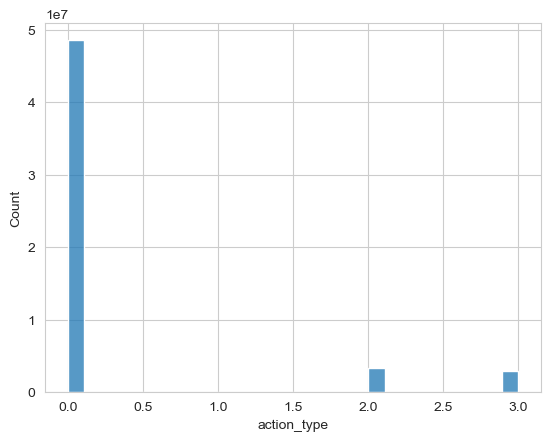

In [87]:
sns.histplot(user_log['action_type'])

#### Plot the Category Id of different Users.

<Axes: xlabel='cat_id', ylabel='Count'>

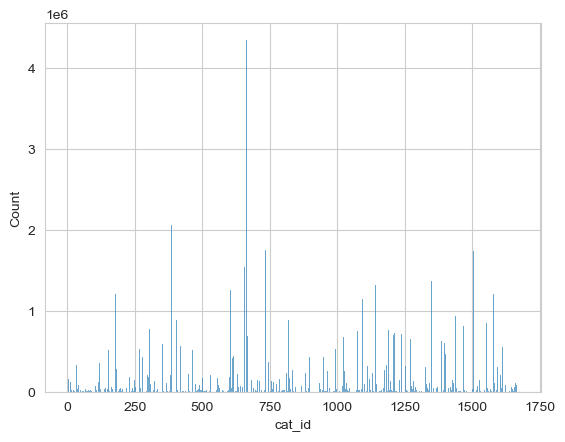

In [88]:
sns.histplot(user_log['cat_id'])

#### Get the Time Stamp as String Type.

In [89]:
user_log['time_str']= user_log['time_stamp'].astype('str')

In [90]:
user_log['time_str'].head()

0    829
1    829
2    829
3    829
4    829
Name: time_str, dtype: object

#### Get the Day of Purchase.

In [91]:
user_log['Day']=user_log['time_stamp']%100

In [92]:
user_log['Day'].head()

0    29
1    29
2    29
3    29
4    29
Name: Day, dtype: int64

#### Get the Month of the Purchase.

In [93]:
user_log['Month']=(user_log['time_stamp']-user_log['Day'])/100

In [94]:
user_log['Month'].head()

0    8.0
1    8.0
2    8.0
3    8.0
4    8.0
Name: Month, dtype: float64

#### Plot the Months of Purchases.

<Axes: xlabel='Month', ylabel='Count'>

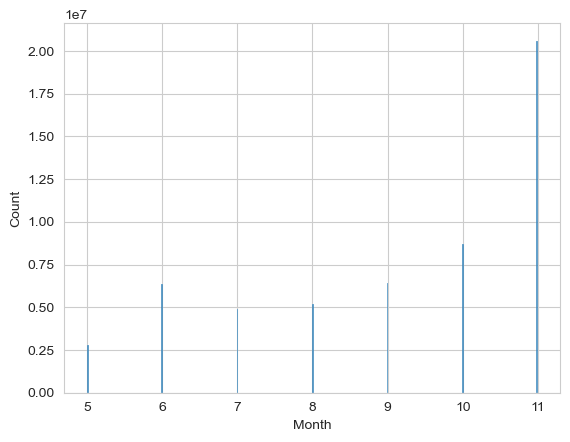

In [95]:
sns.histplot(user_log['Month'])

In [96]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,time_str,Day,Month
0,328862,323294,833,2882,2661.0,829,0,829,29,8.0
1,328862,844400,1271,2882,2661.0,829,0,829,29,8.0
2,328862,575153,1271,2882,2661.0,829,0,829,29,8.0
3,328862,996875,1271,2882,2661.0,829,0,829,29,8.0
4,328862,1086186,1271,1253,1049.0,829,0,829,29,8.0


#### Get User and Category Details.

In [97]:
#user_id and category
user_cat_count= user_log.groupby(['user_id','cat_id']).size()

#### Get User, Category and Click Count.

In [98]:
user_cat_click_count = user_log.groupby(['user_id','cat_id','action_type']).size().to_frame()

In [99]:
user_cat_click_count.head()

0
user_id cat_id action_type    
1       276    0             5
        389    0             2
        992    0            10
               2             4
        1023   0             3

#### Get Category and Action Count.

In [100]:
#category action
cat_click_count = user_log.groupby(['cat_id','action_type']).size()
cat_click_count.head()

cat_id  action_type
1       0                 221
        2                  48
        3                  11
2       0              113178
        1                 313
dtype: int64

#### Get Brand and Click Count.

In [101]:
#brand action
brand_click_count = user_log.groupby(['brand_id','action_type']).size()
brand_click_count.head()

brand_id  action_type
1.0       0              3882
          2               316
          3               153
2.0       0                 1
          2                 2
dtype: int64

#### Get Seller and Click Count.

In [102]:
#merchandise action
mer_click_count = user_log.groupby(['item_id','action_type']).size()
mer_click_count.head()

item_id  action_type
1        0                 1
2        0              2497
         2               338
         3               256
3        0               110
dtype: int64

#### Get Click Percentage.

In [103]:
click_activity_percent = user_log['action_type'].value_counts(normalize=True)*100

In [104]:
dict_user_cat = dict(zip(user_log['user_id'],user_log['cat_id']))

In [105]:
dict_user_brand = dict(zip(user_log['user_id'],user_log['brand_id']))

In [106]:
dict_user_merch = dict(zip(user_log['user_id'],user_log['item_id']))

In [107]:
#user category click activity
user_cat_total = user_log.groupby(['user_id','cat_id'])['action_type'].count().to_frame()
user_cat_total.head()

action_type
user_id cat_id             
1       276               5
        389               2
        992              14
        1023              4
        1252              7

In [108]:
user_cat_total.columns = ['count total']
user_cat_total.head()

count total
user_id cat_id             
1       276               5
        389               2
        992              14
        1023              4
        1252              7

In [109]:
user_cat_click_count.columns = ['size']

In [110]:
user_cat_click_count.head()

size
user_id cat_id action_type      
1       276    0               5
        389    0               2
        992    0              10
               2               4
        1023   0               3

#### Merge to get User, Category and Percentage.

In [111]:
user_cat_activity = user_cat_total.join(user_cat_click_count,how='left')
user_cat_activity['percentage'] = user_cat_activity['size']/user_cat_activity['count total']

In [112]:
user_cat_activity.head()

count total  size  percentage
user_id cat_id action_type                               
1       276    0                      5     5    1.000000
        389    0                      2     2    1.000000
        992    0                     14    10    0.714286
               2                     14     4    0.285714
        1023   0                      4     3    0.750000

#### Action count and ratio of purchases

In [113]:
def get_action_features(level):
    key_id = [x+'_id' for x in level]
    key_sub = ('_').join(level)
    action = user_log[key_id+['action_type']].copy()
    action_info = label_binarize(np.array(action.action_type), classes=[0,1,2,3])
    action_info = pd.DataFrame(data=action_info, columns=['click','add_to_cart','purchase','add_to_favorite'])
    action[key_sub+'_click']= action_info.click
    action[key_sub+'_add_to_cart']=action_info.add_to_cart
    action[key_sub+'_purchase']=action_info.purchase
    action[key_sub+'_add_to_favorite']=action_info.add_to_favorite
    action = action.groupby(key_id).agg('sum').reset_index()
    action.columns = key_id+['action_type',key_sub+'_click_cnt',key_sub+'_add_to_cart_cnt',key_sub+'_purchase_cnt',key_sub+'_add_to_favorite_cnt']
    action[key_sub+'_action_total_cnt']=action[key_sub+'_click_cnt']+action[key_sub+'_add_to_cart_cnt']+action[key_sub+'_purchase_cnt']+action[key_sub+'_add_to_favorite_cnt']
    action[key_sub+'_purchase_rt']=action[key_sub+'_purchase_cnt']/action[key_sub+'_action_total_cnt'] # purchase ratio
    action = action.drop(columns=['action_type'])
    action.fillna(0)
    return action

#### User Action Count and Ratio of Purchases.

In [114]:
# user action count and ratio of purchases
user_action = get_action_features(['user'])
user_action.head()

,user_id,user_click_cnt,user_add_to_cart_cnt,user_purchase_cnt,user_add_to_favorite_cnt,user_action_total_cnt,user_purchase_rt
0,1,27,0,6,0,33,0.181818
1,2,47,0,14,2,63,0.222222
2,3,63,0,4,1,68,0.058824
3,4,49,0,1,0,50,0.020000
4,5,150,0,13,10,173,0.075145


#### Seller Action Count and Ratio of Purchases.

In [115]:
# seller action count and ratio of purchases
seller_action = get_action_features(['seller'])
seller_action.head()

,seller_id,seller_click_cnt,seller_add_to_cart_cnt,seller_purchase_cnt,seller_add_to_favorite_cnt,seller_action_total_cnt,seller_purchase_rt
0,1,308236,444,17705,12755,339140,0.052206
1,2,2030,8,189,144,2371,0.079713
2,3,2399,4,67,175,2645,0.025331
3,4,2646,2,294,164,3106,0.094656
4,5,7483,9,144,556,8192,0.017578


#### User - Seller Action Count and Ratio of Purchases.

In [116]:
# user-seller action count and ratio of purchases
user_seller_action = get_action_features(['user','seller'])
user_seller_action.head()

,user_id,seller_id,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,1,471,1,0,0,0,1,0.000000
1,1,739,1,0,0,0,1,0.000000
2,1,925,3,0,1,0,4,0.250000
3,1,1019,10,0,4,0,14,0.285714
4,1,1156,1,0,0,0,1,0.000000


In [117]:
train_df = train_df.rename(columns={'merchant_id':'seller_id'})

In [118]:
test_df = test_df.rename(columns={'merchant_id':'seller_id'})

In [119]:
# join action
train = pd.merge(train_df,user_action,on=['user_id'],how='left')
train = pd.merge(train_df,seller_action,on=['seller_id'],how='left')
train = pd.merge(train_df,user_seller_action,on=['user_id','seller_id'],how='left')

test = pd.merge(test_df,user_action,on=['user_id'],how='left')
test = pd.merge(test_df,seller_action,on=['seller_id'],how='left')
test = pd.merge(test_df,user_seller_action,on=['user_id','seller_id'],how='left')

#### Day count and Ratio of Purchases

In [120]:
def get_day_features(level):
    key_id = [x+'_id' for x in level]
    key_sub = ('_').join(level)
    action=user_log[key_id+['time_stamp','action_type']].copy()
    action_total_days = user_log[key_id+['time_stamp']].drop_duplicates().groupby(key_id).size().reset_index()
    action_info = label_binarize(np.array(action.action_type), classes=[0,1,2,3])
    action_info = pd.DataFrame(data=action_info, columns=['click','add_to_cart','purchase','add_to_favorite'])
    action[key_sub+'_click']= action_info.click
    action[key_sub+'_add_to_cart']=action_info.add_to_cart
    action[key_sub+'_purchase']=action_info.purchase
    action[key_sub+'_add_to_favorite']=action_info.add_to_favorite
    action = action.groupby(key_id+['time_stamp']).agg('sum').reset_index() # daily action count
    action = action.groupby(key_id).apply(lambda x:(x!=0).sum()) # action day count
    action.drop(columns=key_id+['action_type','time_stamp'],inplace=True)
    action = action.reset_index()
    action_day = pd.merge(action,action_total_days,on=key_id,how='left')
    action_day.columns = key_id+[key_sub+'_click_days',key_sub+'_add_to_cart_days',key_sub+'_purchase_days',key_sub+'_add_to_favorite_days',key_sub+'_action_total_days']    
    action_day[key_sub+'_purchase_day_rt']=action_day[key_sub+'_purchase_days']/action_day[key_sub+'_action_total_days'] # purchase ratio
    action_day.fillna(0)
    return(action_day)

#### Get All the Features of the User.

In [121]:
user_day = get_day_features(['user'])
user_day.head()

/var/folders/h0/_0_5_t_964nftmnhr5sl18mw0000gn/T/ipykernel_2296/3692379564.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  action = action.groupby(key_id).apply(lambda x:(x!=0).sum()) # action day count


,user_id,user_click_days,user_add_to_cart_days,user_purchase_days,user_add_to_favorite_days,user_action_total_days,user_purchase_day_rt
0,1,5,0,3,0,5,0.600000
1,2,5,0,5,2,9,0.555556
2,3,12,0,3,1,13,0.230769
3,4,10,0,1,0,10,0.100000
4,5,29,0,7,9,30,0.233333


#### Get All the Features of the Seller.

In [122]:
seller_day = get_day_features(['seller'])
seller_day.head()

/var/folders/h0/_0_5_t_964nftmnhr5sl18mw0000gn/T/ipykernel_2296/3692379564.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  action = action.groupby(key_id).apply(lambda x:(x!=0).sum()) # action day count


,seller_id,seller_click_days,seller_add_to_cart_days,seller_purchase_days,seller_add_to_favorite_days,seller_action_total_days,seller_purchase_day_rt
0,1,176,55,185,185,185,1.000000
1,2,169,6,54,84,177,0.305085
2,3,168,4,31,79,172,0.180233
3,4,176,2,117,99,180,0.650000
4,5,176,6,64,154,184,0.347826


#### Get all the Features of User and Seller.

In [123]:
# user_seller_day = get_day_features(['user', 'seller'])
# user_seller_day.head()

#### Write all the Features into Files.

In [124]:
seller_day.to_csv(r'seller_day.csv',index = False,header=True)
user_day.to_csv(r'user_day.csv',index = False,header=True)
user_seller_action.to_csv(r'user_seller_action.csv',index = False,header=True)
seller_action.to_csv(r'seller_action.csv',index = False,header=True)
user_action.to_csv(r'user_action.csv',index = False,header=True)
# user_seller_day.to_csv(r'user_seller_day.csv',index = False,header=True)

#### Write the Train, Test Data into Files. 

In [125]:
train.to_csv(r'train_data.csv',index = False,header=True)
test.to_csv(r'test_data.csv',index = False,header=True)

#### Read the data from Files.

In [126]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
seller_action = pd.read_csv('seller_action.csv')
seller_day = pd.read_csv('seller_day.csv')
user_action = pd.read_csv('user_action.csv')
user_day = pd.read_csv('user_day.csv')
user_seller_action = pd.read_csv('user_seller_action.csv')
user_seller_day = pd.read_csv('user_seller_day.csv')

#### Prepare Test and Train DataSets.

In [127]:
# join day
train = pd.merge(train,user_day,on=['user_id'],how='left')
train = pd.merge(train,seller_day,on=['seller_id'],how='left')

test = pd.merge(test,user_day,on=['user_id'],how='left')
test = pd.merge(test,seller_day,on=['seller_id'],how='left')
test = pd.merge(test,user_seller_day,on=['user_id','seller_id'],how='left')

#### Product Diversity

#### Seller - Item 

In [128]:
seller_item = user_log[['seller_id','item_id']].copy()
seller_item.drop_duplicates(['item_id'], inplace=True)
seller_item= seller_item.groupby('seller_id').size().reset_index()
seller_item.columns = ['seller_id','seller_item_cnt']
seller_item.head()

,seller_id,seller_item_cnt
0,1,2977
1,2,154
2,3,171
3,4,155
4,5,660


#### Seller - Brand

In [129]:
seller_brand = user_log[['seller_id','brand_id']].copy()
seller_brand.drop_duplicates(['brand_id'], inplace=True)
seller_brand = seller_brand.groupby('seller_id').size().reset_index()
seller_brand.columns = ['seller_id','seller_brand_cnt']
seller_brand.head()

,seller_id,seller_brand_cnt
0,1,2
1,3,1
2,4,1
3,5,1
4,6,1


#### Seller - Category

In [130]:
seller_cat = user_log[['seller_id','cat_id']].copy()
seller_cat.drop_duplicates(['cat_id'], inplace=True)
seller_cat = seller_cat.groupby('seller_id').size().reset_index()
seller_cat.columns = ['seller_id','seller_cat_cnt']
seller_cat.head()

,seller_id,seller_cat_cnt
0,1,1
1,15,1
2,16,1
3,19,1
4,21,1


#### User - Item

In [131]:
user_item = user_log[['user_id','item_id']].copy()
user_item.drop_duplicates(['item_id'],inplace=True)
user_item = user_item.groupby('user_id').size().reset_index()
user_item.columns = ['user_id','user_item_cnt']
user_item.head()

,user_id,user_item_cnt
0,5,2
1,6,3
2,9,1
3,10,1
4,14,2


#### User - Category

In [132]:
user_cat = user_log[['user_id','cat_id']].copy()
user_cat.drop_duplicates(['cat_id'],inplace=True)
user_cat = user_cat.groupby('user_id').size().reset_index()
user_cat.columns = ['user_id','user_cat_cnt']
user_cat.head()

,user_id,user_cat_cnt
0,16,2
1,19,2
2,62,1
3,941,1
4,1920,1


#### User - Brand

In [133]:
user_brand = user_log[['user_id','brand_id']].copy()
user_brand.drop_duplicates(['brand_id'],inplace=True)
user_brand = user_cat.groupby('user_id').size().reset_index()
user_brand.columns = ['user_id','user_brand_cnt']
user_brand.head()

,user_id,user_brand_cnt
0,16,1
1,19,1
2,62,1
3,941,1
4,1920,1


#### User - Seller

In [134]:
user_seller_item = user_log[['user_id','seller_id','item_id']].copy()
user_seller_item.drop_duplicates(inplace=True)
user_seller_item = user_seller_item.groupby(['user_id','seller_id']).size().reset_index()
user_seller_item.columns = ['user_id','seller_id','user_seller_item_cnt']
user_seller_item.head()

,user_id,seller_id,user_seller_item_cnt
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### User - Seller - Brand

In [135]:
user_seller_brand = user_log[['user_id','seller_id','brand_id']].copy()
user_seller_brand.drop_duplicates(inplace=True)
user_seller_brand = user_seller_brand.groupby(['user_id','seller_id']).size().reset_index()
user_seller_brand.columns = ['user_id','seller_id','user_seller_brand_cnt']
user_seller_brand.head()

,user_id,seller_id,user_seller_brand_cnt
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### User - Seller - Category

In [136]:
user_seller_cat = user_log[['user_id','seller_id','cat_id']].copy()
user_seller_cat.drop_duplicates(inplace=True)
user_seller_cat = user_seller_cat.groupby(['user_id','seller_id']).size().reset_index()
user_seller_cat.columns = ['user_id','seller_id','user_seller_cat_cnt']
user_seller_cat.head()

,user_id,seller_id,user_seller_cat_cnt
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


#### Merge Producs data with the Train Dataset.

In [137]:
# join product diversity
train = pd.merge(train,user_brand,on=['user_id'],how='left')

In [138]:
train = pd.merge(train,user_cat,on=['user_id'],how='left')

In [139]:
train = pd.merge(train,user_item,on=['user_id'],how='left')

In [140]:
train = pd.merge(train,seller_brand,on=['seller_id'],how='left')

In [141]:
train = pd.merge(train,seller_cat,on=['seller_id'],how='left')

In [142]:
train = pd.merge(train,seller_item,on=['seller_id'],how='left')

In [143]:
train = pd.merge(train,user_seller_brand,on=['user_id','seller_id'],how='left')

In [144]:
train = pd.merge(train,user_seller_cat,on=['user_id','seller_id'],how='left')

In [145]:
train = pd.merge(train,user_seller_item,on=['user_id','seller_id'],how='left')

#### Merge Producs data with the Test Dataset.

In [146]:
test = pd.merge(test,user_brand,on=['user_id'],how='left')

In [147]:
test = pd.merge(test,user_cat,on=['user_id'],how='left')

In [148]:
test = pd.merge(test,user_item,on=['user_id'],how='left')

In [149]:
test = pd.merge(test,seller_brand,on=['seller_id'],how='left')

In [150]:
test = pd.merge(test,seller_cat,on=['seller_id'],how='left')

In [151]:
test = pd.merge(test,seller_item,on=['seller_id'],how='left')

In [152]:
test = pd.merge(test,user_seller_brand,on=['user_id','seller_id'],how='left')

In [153]:
test = pd.merge(test,user_seller_cat,on=['user_id','seller_id'],how='left')

In [154]:
test = pd.merge(test,user_seller_item,on=['user_id','seller_id'],how='left')

#### User - Seller Similarity

#### Seller Market Share on Brand

In [155]:
# merchant’s market share on the brand = NMB/NB
seller_mkt_share_brand = user_log[['seller_id','brand_id']].copy()
seller_mkt_share_brand = seller_mkt_share_brand.groupby(['seller_id','brand_id']).size().reset_index()
seller_mkt_share_brand.columns = ['seller_id','brand_id','NMB']
seller_mkt_share_brand['seller_mkt_share_brand'] = seller_mkt_share_brand['NMB']/seller_mkt_share_brand.groupby('brand_id')['NMB'].transform('sum')
seller_mkt_share_brand = seller_mkt_share_brand.drop(columns=['NMB'])
seller_mkt_share_brand.head()

,seller_id,brand_id,seller_mkt_share_brand
0,1,1104.0,1.000000
1,1,1662.0,0.996967
2,2,2921.0,0.283946
3,3,970.0,1.000000
4,4,1944.0,1.000000


#### User Seller Simillarity on Brand.

In [156]:
# user-merchant similarity on brand
user_mkt_share_brand = user_log.groupby(['user_id','brand_id']).size().reset_index()
user_mkt_share_brand.columns = ['user_id','brand_id','NUB']
user_seller_brand_similarity = user_log[['user_id','seller_id','brand_id']].copy()
user_seller_brand_similarity.drop_duplicates(inplace=True)
user_seller_brand_similarity = pd.merge(user_seller_brand_similarity,seller_mkt_share_brand,on=['seller_id','brand_id'],how='left')
user_seller_brand_similarity = pd.merge(user_seller_brand_similarity,user_mkt_share_brand,on=['user_id','brand_id'],how='left')
user_seller_brand_similarity.fillna(0)
user_seller_brand_similarity['brand_similarity_score'] = user_seller_brand_similarity['seller_mkt_share_brand']*user_seller_brand_similarity['NUB']
user_seller_brand_similarity = user_seller_brand_similarity.groupby(['user_id','seller_id'])['brand_similarity_score'].agg('sum').reset_index()
user_seller_brand_similarity.head()

,user_id,seller_id,brand_similarity_score
0,1,471,1.000000
1,1,739,1.000000
2,1,925,2.402976
3,1,1019,14.000000
4,1,1156,1.000000


#### User Seller Simillarity on Category.

In [157]:
# user-merchant similarity on category
seller_mkt_share_cat = user_log[['seller_id','cat_id']].copy()
seller_mkt_share_cat = seller_mkt_share_cat.groupby(['seller_id','cat_id']).size().reset_index()
seller_mkt_share_cat.columns = ['seller_id','cat_id','NMC']
seller_mkt_share_cat['seller_mkt_share_cat'] = seller_mkt_share_cat['NMC']/seller_mkt_share_cat.groupby('cat_id')['NMC'].transform('sum')
seller_mkt_share_cat = seller_mkt_share_cat.drop(columns=['NMC'])

user_mkt_share_cat = user_log.groupby(['user_id','cat_id']).size().reset_index()
user_mkt_share_cat.columns = ['user_id','cat_id','NUC']

user_seller_cat_similarity = user_log[['user_id','seller_id','cat_id']].copy()
user_seller_cat_similarity.drop_duplicates(inplace=True)
user_seller_cat_similarity = pd.merge(user_seller_cat_similarity,seller_mkt_share_cat,on=['seller_id','cat_id'],how='left')
user_seller_cat_similarity = pd.merge(user_seller_cat_similarity,user_mkt_share_cat,on=['user_id','cat_id'],how='left')
user_seller_cat_similarity.fillna(0)
user_seller_cat_similarity['cat_similarity_score'] = user_seller_cat_similarity['seller_mkt_share_cat']*user_seller_cat_similarity['NUC']
user_seller_cat_similarity = user_seller_cat_similarity.groupby(['user_id','seller_id'])['cat_similarity_score'].agg('sum').reset_index()
user_seller_cat_similarity.head()

,user_id,seller_id,cat_similarity_score
0,1,471,0.004445
1,1,739,0.086667
2,1,925,0.069735
3,1,1019,0.236661
4,1,1156,0.333996


#### Merge Similarity with the Train and Test Datasets.

In [158]:
# join similarity
train = pd.merge(train,user_seller_brand_similarity,on=['user_id','seller_id'],how='left')
train = pd.merge(train,user_seller_cat_similarity,on=['user_id','seller_id'],how='left')

test = pd.merge(test,user_seller_brand_similarity,on=['user_id','seller_id'],how='left')
test = pd.merge(test,user_seller_cat_similarity,on=['user_id','seller_id'],how='left')

#### Write the Train, Test Data into Files.

In [159]:
# save
train.to_csv(r'train_data_similarity.csv',index = False,header=True)
test.to_csv(r'test_data_similarity.csv',index = False,header=True)

## Initial Model Fit.

#### Load Train Data.

In [160]:
#load data
train = pd.read_csv('train_data.csv')
train.head()

,user_id,seller_id,label,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,34176,3906,0,36,0,1,2,39,0.025641
1,34176,121,0,13,0,1,0,14,0.071429
2,34176,4356,1,12,0,6,0,18,0.333333
3,34176,2217,0,1,0,1,0,2,0.500000
4,230784,4818,0,7,0,1,0,8,0.125000


#### Load Test Data.

In [161]:
test = pd.read_csv('test_data.csv')
test.head()

,user_id,seller_id,prob,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,163968,4605,NaN,1,0,1,0,2,0.500000
1,360576,1581,NaN,5,0,5,0,10,0.500000
2,98688,1964,NaN,5,0,1,0,6,0.166667
3,98688,3645,NaN,10,0,1,0,11,0.090909
4,295296,3361,NaN,47,0,1,2,50,0.020000


#### Replace all Infinity values with 0.

In [162]:
train = train.replace(np.inf, 0)
test = test.replace(np.inf, 0)

#### Split the Data into Train and Test Data.

In [163]:
#data split (training_set, testing_set)
X = train.drop('label',axis=1)
y = train.label
#unbalanced
y.sum()/y.count()

0.06115063788027478

In [164]:
training_set_x, testing_set_x, training_set_y, testing_set_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [165]:
print(training_set_x.shape, testing_set_x.shape, training_set_y.shape, testing_set_y.shape)

(182604, 8) (78260, 8) (182604,) (78260,)


In [166]:
np.isfinite(training_set_x).all()

user_id                            True
seller_id                          True
user_seller_click_cnt              True
user_seller_add_to_cart_cnt        True
user_seller_purchase_cnt           True
user_seller_add_to_favorite_cnt    True
user_seller_action_total_cnt       True
user_seller_purchase_rt            True
dtype: bool

In [167]:
training_set_x_id = training_set_x[['user_id','seller_id']]
testing_set_x_id = testing_set_x[['user_id', 'seller_id']]
training_set_x = training_set_x.drop(['user_id','seller_id'], axis=1)
testing_set_x = testing_set_x.drop(['user_id','seller_id'], axis=1)

### Modeling on Original Dataset.

### Random Forest Modeling.

In [168]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap= True,max_features ='sqrt')

#### Fit the Training Data.

In [169]:
#fit on training data
model_rf.fit(training_set_x, training_set_y)

RandomForestClassifier()

#### Predict using the Training Data.

In [170]:
#predictions
rf_predictions = model_rf.predict(testing_set_x)
rf_probs = model_rf.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [171]:
#check model accuracy, ROC AUC
print('Accuracy:',metrics.accuracy_score(testing_set_y, rf_predictions))
print('ROC AUC:', metrics.roc_auc_score(testing_set_y, rf_probs))

Accuracy: 0.9366087400971121
ROC AUC: 0.5699488405749995


In [172]:
np.mean(rf_predictions)

0.0020955788397648864

### Gradient Boosting Modeling

In [173]:
#Gradient Boosting
model_gbm = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',learning_rate=0.03)

#### Fit the Training Data.

In [174]:
#fit on training data
model_gbm.fit(training_set_x, training_set_y)

[LightGBM] [Info] Number of positive: 11109, number of negative: 171495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 182604, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060837 -> initscore=-2.736799
[LightGBM] [Info] Start training from score -2.736799


LGBMClassifier(learning_rate=0.03, metric='binary_logloss', objective='binary')

#### Predict using the Training Data.

In [175]:
#predictions
gbm_predictions = model_gbm.predict(testing_set_x)
gbm_probs = model_gbm.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [176]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, gbm_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, gbm_probs))

Accuracy: 0.9381165346281626
ROC AUC 0.6012881589388724


In [177]:
np.mean(gbm_predictions)

0.0

In [178]:
training_set_x[training_set_x.isna()]

,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
230730,NaN,NaN,NaN,NaN,NaN,NaN
56754,NaN,NaN,NaN,NaN,NaN,NaN
47597,NaN,NaN,NaN,NaN,NaN,NaN
235600,NaN,NaN,NaN,NaN,NaN,NaN
217419,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
229119,NaN,NaN,NaN,NaN,NaN,NaN
5192,NaN,NaN,NaN,NaN,NaN,NaN
208780,NaN,NaN,NaN,NaN,NaN,NaN
229611,NaN,NaN,NaN,NaN,NaN,NaN


### XGBoost Modeling

In [179]:
#XGB
model_xgb = XGBClassifier(objective ='binary:logistic', learning_rate=0.1)

#### Fit the Training Data.

In [180]:
#fit on training data
model_xgb.fit(training_set_x, training_set_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predict using the Training Data.

In [181]:
#predictions
xgb_predictions = model_xgb.predict(testing_set_x)
xgb_probs = model_xgb.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [182]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, xgb_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, xgb_probs))

Accuracy: 0.9381293125479172
ROC AUC 0.5988589344239361


In [183]:
np.mean(xgb_predictions)

8.944543828264758e-05

### Modeling on Oversampling Data.

#### OverSampling Data using SMOTE

In [184]:
#SMOTE
sm = SMOTE(random_state=2)
training_set_x.fillna(training_set_x.mean(), inplace=True)

#### Fit Train Data into SMOTE.

In [185]:
training_set_x_res, training_set_y_res = sm.fit_resample(training_set_x, training_set_y)

#### Calculate Percentage after OverSampling.

In [186]:
#Percentage of output after oversampling
print('After oversampling, counts of label 1:',format(sum(training_set_y_res==1)))
print('After oversampling, counts of label 0:',format(sum(training_set_y_res==0)))

After oversampling, counts of label 1: 171495
After oversampling, counts of label 0: 171495


### Random Forest Modeling.

In [187]:
#random forest model fitting with over sampling data
model_rf_2 = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap= True,max_features ='sqrt')

#### Fit the Training Data.

In [188]:
#fit on training data
model_rf_2.fit(training_set_x_res, training_set_y_res)

RandomForestClassifier()

#### Predict using the Training Data.

In [189]:
#predictions
rf2_predictions = model_rf_2.predict(testing_set_x)
rf2_probs = model_rf_2.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [190]:
#check model accuracy, ROC AUC
print('Accuracy:',metrics.accuracy_score(testing_set_y, rf2_predictions))
print('ROC AUC:', metrics.roc_auc_score(testing_set_y, rf2_probs))

Accuracy: 0.7501788908765653
ROC AUC: 0.539809078578964


In [191]:
np.mean(rf2_predictions)

0.22624584717607973

### Gradient Boosting Modeling

In [192]:
#Gradient Boosting
model_gbm_2 = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',learning_rate=0.03)

#### Fit the Training Data.

In [193]:
#fit on training data
model_gbm_2.fit(training_set_x_res, training_set_y_res)

[LightGBM] [Info] Number of positive: 171495, number of negative: 171495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 342990, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.03, metric='binary_logloss', objective='binary')

#### Predict using the Training Data.

In [194]:
#predictions
gbm2_predictions = model_gbm_2.predict(testing_set_x)
gbm2_probs = model_gbm_2.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [195]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, gbm2_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, gbm2_probs))

Accuracy: 0.7056222846920521
ROC AUC 0.5969690725828767


In [196]:
np.mean(gbm2_predictions)

0.28498594428826984

### XGBoost Modeling

In [197]:
#XGB
model_xgb_2 = XGBClassifier(objective ='binary:logistic', learning_rate=0.1)

#### Fit the Training Data.

In [198]:
#fit on training data
model_xgb_2.fit(training_set_x_res, training_set_y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predict using the Training Data.

In [199]:
#predictions
xgb_2_predictions = model_xgb_2.predict(testing_set_x)
xgb_2_probs = model_xgb_2.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [200]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, xgb_2_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, xgb_2_probs))

Accuracy: 0.6990033222591362
ROC AUC 0.5905747526558434


In [201]:
np.mean(xgb_2_predictions)

0.2915026833631485

### Modeling on Undersampling Data.

#### UnderSampling Data using Random Under Sampler.

In [202]:
#RUS (under sampling)
rus = RandomUnderSampler()

#### Fit Train Data into RUS.

In [203]:
training_x_rus, training_y_rus = rus.fit_resample(training_set_x, training_set_y)

#### Calculate Percentage after UnderSampling.

In [204]:
#print percentage of output after oversampling
print('After undersampling, counts of label 1:',format(sum(training_y_rus==1)))
print('After undersampling, counts of label 0:',format(sum(training_y_rus==0)))

After undersampling, counts of label 1: 11109
After undersampling, counts of label 0: 11109


### Random Forest Modeling.

In [205]:
#random forest model fitting with under sampling data
model_rf_3 = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap= True,max_features ='sqrt')

#### Fit the Training Data.

In [206]:
#fit on training data
model_rf_3.fit(training_x_rus, training_y_rus)

RandomForestClassifier()

#### Predict using the Training Data.

In [207]:
#predictions
rf3_predictions = model_rf_3.predict(testing_set_x)
rf3_probs = model_rf_3.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [208]:
#check model accuracy, ROC AUC
print('Accuracy:',metrics.accuracy_score(testing_set_y, rf3_predictions))
print('ROC AUC:', metrics.roc_auc_score(testing_set_y, rf3_probs))

Accuracy: 0.6801431127012523
ROC AUC: 0.574830443317362


In [209]:
np.mean(rf3_predictions)

0.31028622540250445

### Gradient Boosting Modeling

In [210]:
#Gradient Boosting
model_gbm_3 = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',learning_rate=0.03)

#### Fit the Training Data.

In [211]:
#fit on training data
model_gbm_3.fit(training_x_rus, training_y_rus)

[LightGBM] [Info] Number of positive: 11109, number of negative: 11109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 22218, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.03, metric='binary_logloss', objective='binary')

#### Predict using the Training Data.

In [212]:
#predictions
gbm3_predictions = model_gbm_3.predict(testing_set_x)
gbm3_probs = model_gbm_3.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [213]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, gbm3_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, gbm3_probs))

Accuracy: 0.6968694096601074
ROC AUC 0.6000482885334004


In [214]:
np.mean(gbm3_predictions)

0.2956810631229236

### XGBoost Modeling

In [215]:
#XGB
model_xgb_3 = XGBClassifier(objective='binary:logistic', learning_rate=0.1)

#### Fit the Training Data.

In [216]:
#fit on training data
model_xgb_3.fit(training_x_rus, training_y_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predict using the Training Data.

In [217]:
#predictions
xgb_3_predictions = model_xgb_3.predict(testing_set_x)
xgb_3_probs = model_xgb_3.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [218]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, xgb_3_predictions))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, xgb_3_probs))

Accuracy: 0.676424738052645
ROC AUC 0.5963410086200406


In [219]:
np.mean(xgb_3_predictions)

0.3183490927676974

## Sampler CV

In [220]:
train_X = X.drop(['user_id','seller_id'], axis=1)
train_X.head()

,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,36,0,1,2,39,0.025641
1,13,0,1,0,14,0.071429
2,12,0,6,0,18,0.333333
3,1,0,1,0,2,0.500000
4,7,0,1,0,8,0.125000


#### K-Fold Cross Validation using diff. Sampling Method.

In [221]:
# define imbalanced stratified k-fold cross validation with different sampling method
def imbalance_cv_score(model, x, y, cv, scoring, sampling_method):
    '''
    This function computes the cross-validation score using a selected sampling method to adjust imbalance dataset, using 
    stratified k-fold cross validation. 
    
    The first five arguments are the same with cross_val_score in sklearn package
    
    model = selected machine learning model
    x = data input
    y = data outcome(label)
    cv = number of folds(k)
    scoring = scoring metrics selected for evaluation. *Currently support accuracy_score, balance_accuracy, 
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, ndcg_score in sklearn.metrics package*
    sampling_method: choice of random sampler: Object that is similar to sampler object from python imbalanced-learn package
    with the method sampling_method.fit_sample()

    '''
    cv_score = []
    test_score = 0
    cv_method = StratifiedKFold(n_splits=cv)
    pred_score_method_list = [metrics.accuracy_score,metrics.balanced_accuracy_score,metrics.f1_score, metrics.precision_score,
                             metrics.recall_score]
    pred_prob_method_list = [metrics.roc_auc_score,metrics.average_precision_score,metrics.ndcg_score]
    for train_index, test_index in cv_method.split(x,y):
        xfold_train, yfold_train = sampling_method.fit_resample(x.iloc[train_index],y.iloc[train_index])
        model.fit(xfold_train, yfold_train)
        model_predictions = model.predict(x.iloc[test_index])
        model_probs = model.predict_proba(x.iloc[test_index])[:, 1]
        if scoring in pred_score_method_list:
            score = scoring(y.iloc[test_index], model_predictions)
        elif scoring in pred_prob_method_list:
            score = scoring(y.iloc[test_index], model_probs)
        else:
            print('Sorry, Current scoring method not available now.')
        cv_score.append(score)
    return cv_score

#### Define all the Modeling Techniques.

In [222]:
Random_forest_model = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap= True,max_features ='sqrt')
GBM_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',learning_rate=0.03)
XGB_model = XGBClassifier(objective ='binary:logistic', learning_rate=0.1)
model_list= [Random_forest_model, GBM_model, XGB_model]
sampler_list = [SMOTE(),RandomUnderSampler(),ADASYN()]
results_acc = []
time_res = []
names = []
for model in model_list:
    name = model.__class__.__name__
    for sm in sampler_list:
        start = time()
        sm_name = sm.__class__.__name__
        train_X.fillna(train_X.mean(), inplace=True)
        scores = imbalance_cv_score(model, train_X, y, 5, metrics.accuracy_score, sm)
        results_acc.append(mean(scores))
        names.append(name)
        end = time()
        time_use = end - start
        time_res.append(time_use)
        print('The accuracy score for ', name, 'is ', mean(scores), 
              'with the Std of', stdev(scores), 'using sampling method ', sm_name, 'in time: ',time_use)

The accuracy score for  RandomForestClassifier is  0.740098247954229 with the Std of 0.009396197710748037 using sampling method  SMOTE in time:  47.562474966049194
The accuracy score for  RandomForestClassifier is  0.6927287213399883 with the Std of 0.012496772831921635 using sampling method  RandomUnderSampler in time:  5.654301166534424
The accuracy score for  RandomForestClassifier is  0.7061878226835082 with the Std of 0.02079175984713231 using sampling method  ADASYN in time:  48.361526012420654
[LightGBM] [Info] Number of positive: 195929, number of negative: 195929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 391858, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

#### Create DataFrames for Metrics.

In [223]:
time_res = pd.DataFrame(time_res, columns=['Time'])
acc_res = pd.DataFrame(results_acc, columns=['Accuracy_score'])

#### Calculate Metrics for all the Modeling Techniques.

In [224]:
results_auc = []
names = []
time_res_2 = []
for model in model_list:
    name = model.__class__.__name__
    for sm in sampler_list:
        start = time()
        sm_name = sm.__class__.__name__
        scores = imbalance_cv_score(model, train_X, y, 5, metrics.roc_auc_score, sm)
        results_auc.append(mean(scores))
        names.append(name)
        end = time()
        time_use = end - start
        time_res_2.append(time_use)
        print('The AUC score for ', name, 'is ', mean(scores), 
              'with the Std of',stdev(scores), 'using sampling method ', sm_name, 'in time: ',time_use)

The AUC score for  RandomForestClassifier is  0.5377162083042563 with the Std of 0.006001242917382581 using sampling method  SMOTE in time:  47.22152495384216
The AUC score for  RandomForestClassifier is  0.5840808506761291 with the Std of 0.007063778233938027 using sampling method  RandomUnderSampler in time:  5.645920991897583
The AUC score for  RandomForestClassifier is  0.5339013955326626 with the Std of 0.0044892182385584695 using sampling method  ADASYN in time:  48.334275007247925
[LightGBM] [Info] Number of positive: 195929, number of negative: 195929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 391858, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Li

#### Store all the Metrics in the Metrics DataFrames

In [225]:
auc_res = pd.DataFrame(results_auc, columns=['AUC_score'])
sampler = pd.DataFrame({'Sampler_method':['SMOTE','RandomUnderSampler','ADASYN','SMOTE','RandomUnderSampler','ADASYN',
                                        'SMOTE','RandomUnderSampler','ADASYN']})
coef = pd.concat([time_res, acc_res, auc_res, sampler],axis=1)
coef.index=['RF','RF','RF','GBM','GBM','GBM','XGB','XGB','XGB']

#### Write Metrics of all the Modeling Techniques into a File.

In [226]:
coef.to_csv('Coef.csv')

In [227]:
coef

,Time,Accuracy_score,AUC_score,Sampler_method
RF,47.562475,0.740098,0.537716,SMOTE
RF,5.654301,0.692729,0.584081,RandomUnderSampler
RF,48.361526,0.706188,0.533901,ADASYN
GBM,3.747107,0.685453,0.603738,SMOTE
GBM,1.212541,0.687416,0.606408,RandomUnderSampler
GBM,5.903822,0.662307,0.600557,ADASYN
XGB,2.407753,0.687155,0.597386,SMOTE
XGB,0.575143,0.690122,0.603212,RandomUnderSampler
XGB,5.238059,0.664277,0.592625,ADASYN


## Best Modeling Technique.

#### Data OverSampling using SMOTE.

In [228]:
# data sampling using SMOTE
sm = SMOTE()

#### Fit Training Data into SMOTE.

In [229]:
training_x_sm, training_y_sm = sm.fit_resample(training_set_x, training_set_y)

#### Calculate Percentage after OverSampling.

In [230]:
#print percentage of output after oversampling
print('After oversampling, counts of label 1:',format(sum(training_y_sm==1)))
print('After oversampling, counts of label 0:',format(sum(training_y_sm==0)))

After oversampling, counts of label 1: 171495
After oversampling, counts of label 0: 171495


#### Plot Output Distribution.

Text(0, 0.5, 'Number of Records')

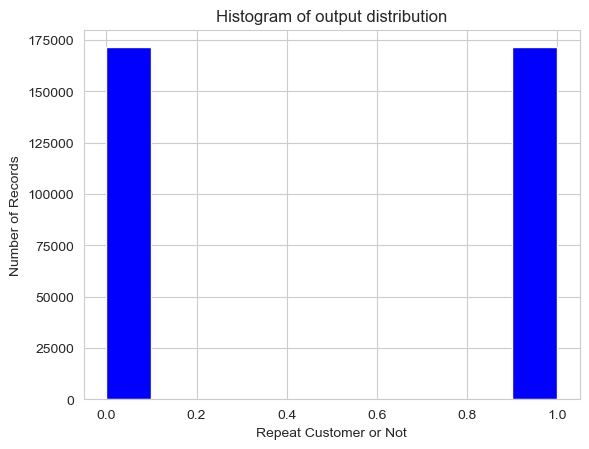

In [231]:
#plot output distribution after oversampling
plt.hist(training_y_sm, color='blue')
plt.title('Histogram of output distribution')
plt.xlabel('Repeat Customer or Not')
plt.ylabel('Number of Records')

### XGBoost Modeling.

In [232]:
#  best model
XGB_model = XGBClassifier(objective ='binary:logistic', learning_rate=0.1)

#### Fit the Training Data.

In [233]:
#fit on training data
XGB_model.fit(training_x_sm, training_y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predict using the Training Data.

In [234]:
#predictions
best_model_pred = XGB_model.predict(testing_set_x)
best_model_probs = XGB_model.predict_proba(testing_set_x)[:, 1]

#### Metrics Calculation of the Model.

In [235]:
#check model accuracy, ROC AUC
print('Accuracy:', metrics.accuracy_score(testing_set_y, best_model_pred))
print('ROC AUC', metrics.roc_auc_score(testing_set_y, best_model_probs))

Accuracy: 0.6996677740863787
ROC AUC 0.5908801946310211


In [236]:
np.mean(best_model_pred)

0.29058267314081265

#### Weightage using get_booster()

In [237]:
XGB_model.get_booster().get_score(importance_type='weight')

{'user_seller_click_cnt': 923.0,
 'user_seller_add_to_cart_cnt': 191.0,
 'user_seller_purchase_cnt': 477.0,
 'user_seller_add_to_favorite_cnt': 876.0,
 'user_seller_action_total_cnt': 847.0,
 'user_seller_purchase_rt': 987.0}

In [238]:
XGB_model.get_booster().get_score(importance_type='gain')

{'user_seller_click_cnt': 11.967562675476074,
 'user_seller_add_to_cart_cnt': 26.40833282470703,
 'user_seller_purchase_cnt': 90.17658996582031,
 'user_seller_add_to_favorite_cnt': 12.972189903259277,
 'user_seller_action_total_cnt': 52.34785079956055,
 'user_seller_purchase_rt': 14.65919017791748}

#### Plot Feature Importance in the Model.

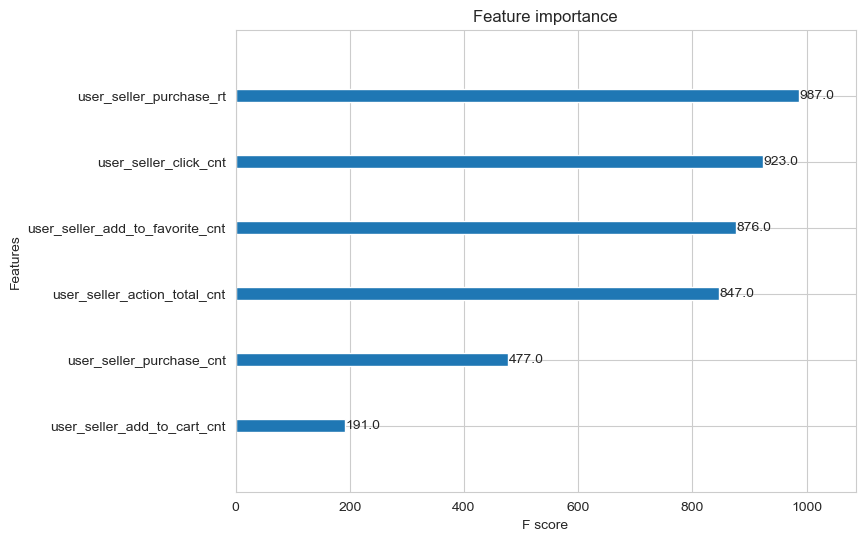

In [239]:
plot_importance(XGB_model, max_num_features=20)
plt.gcf().set_size_inches(8, 6, forward=True)
plt.savefig('feature_importance_plot.png',bbox_inches = "tight")
plt.show()

#### Plot Feature Importance with gain in the Model.

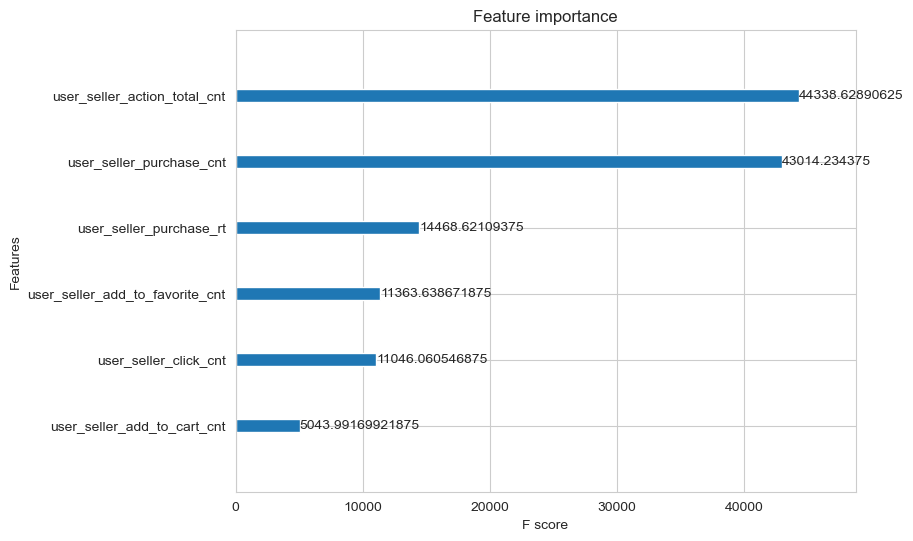

In [240]:
plot_importance(XGB_model.get_booster().get_score(importance_type='total_gain'), max_num_features=20)
plt.gcf().set_size_inches(8, 6, forward=True)
plt.savefig('feature_importance_plot_gain.png', bbox_inches = "tight")
plt.show()

#### Repeat Purchase Prediction.

In [241]:
prediction_output = pd.DataFrame(best_model_pred, columns=['Repeat_Customer'])

#### Check for any Non - Predicted Values.

In [242]:
prediction_output.isnull()

,Repeat_Customer
0,False
1,False
2,False
3,False
4,False
...,...
78255,False
78256,False
78257,False
78258,False


In [243]:
testing_set_x_id.shape

(78260, 2)

In [244]:
final_output = pd.concat([testing_set_x_id.reset_index(drop=True), prediction_output.reset_index(drop=True)], axis=1)

#### Write Prediction into File.

In [245]:
final_output.head()
final_output.to_csv('Repeat_Customer_Prediction.csv')

## Deep Learning with TensorFlow

#### Read Train, Test Data from files.

In [246]:
train = pd.read_csv('train_data.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 9 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_id                          260864 non-null  int64  
 1   seller_id                        260864 non-null  int64  
 2   label                            260864 non-null  int64  
 3   user_seller_click_cnt            260864 non-null  int64  
 4   user_seller_add_to_cart_cnt      260864 non-null  int64  
 5   user_seller_purchase_cnt         260864 non-null  int64  
 6   user_seller_add_to_favorite_cnt  260864 non-null  int64  
 7   user_seller_action_total_cnt     260864 non-null  int64  
 8   user_seller_purchase_rt          260864 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 17.9 MB


In [247]:
test = pd.read_csv('test_data.csv')
test.head()

,user_id,seller_id,prob,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,163968,4605,NaN,1,0,1,0,2,0.500000
1,360576,1581,NaN,5,0,5,0,10,0.500000
2,98688,1964,NaN,5,0,1,0,6,0.166667
3,98688,3645,NaN,10,0,1,0,11,0.090909
4,295296,3361,NaN,47,0,1,2,50,0.020000


#### Classify Label Imbalance

In [248]:
#class label imbalance
neg, pos = np.bincount(train['label'])
total = neg+pos
print('Total:{}\n'
      'Positive:{}({:2f}% of total)\n'.format(total, pos, 100*pos/total))

Total:260864
Positive:15952(6.115064% of total)



#### Replace all Infinity values with 0.

In [249]:
#fill all infinite entry with 0
train = train.replace(np.inf, 0)
test = test.replace(np.inf, 0)

#### Prepare Train, Test Data.

In [251]:
#data split (training_set, testing_set)
data_output = train.label
data_input = train.drop('label',axis=1)
data_input = data_input.drop(['user_id', 'seller_id'], axis=1)

In [252]:
training_set_x, testing_set_x, training_set_y, testing_set_y = train_test_split(data_input, data_output, test_size=0.3, random_state=1)

#### Get Values of Train, Test Data.

In [253]:
train_x = training_set_x.values
train_y = training_set_y.values
test_x = testing_set_x.values
test_y = testing_set_y.values

#form labels
bool_label = train_y != 0

#### Define StandaraScaler()

In [254]:
scaler = StandardScaler()

#### Fit the data into StandardScaler()

In [255]:
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

In [256]:
train_x

array([[-0.4071055 , -0.11283687, -0.39398375, -0.2731045 , -0.42852737,
         0.73208195],
       [-0.4071055 , -0.11283687, -0.39398375, -0.2731045 , -0.42852737,
         0.73208195],
       [-0.3568396 , -0.11283687, -0.39398375, -0.2731045 , -0.38008308,
         0.12433195],
       ...,
       [-0.4071055 , -0.11283687, -0.39398375, -0.2731045 , -0.42852737,
         0.73208195],
       [-0.3568396 , -0.11283687, -0.39398375,  0.43799293, -0.33163878,
        -0.17954305],
       [ 0.44741479, -0.11283687, -0.39398375, -0.2731045 ,  0.39502567,
        -0.899247  ]])

#### Get Pos and Neg Data into a DataFrame.

In [257]:
pos_df = pd.DataFrame(train_x[ bool_label], columns = training_set_x.columns)
neg_df = pd.DataFrame(train_x[~bool_label], columns = training_set_x.columns)

#### Plot Pos and Neg Distribution.

In [310]:
pos_df.columns

Index(['user_seller_click_cnt', 'user_seller_add_to_cart_cnt',
       'user_seller_purchase_cnt', 'user_seller_add_to_favorite_cnt',
       'user_seller_action_total_cnt', 'user_seller_purchase_rt'],
      dtype='object')

Text(0.5, 0.98, 'Negative Distribution')

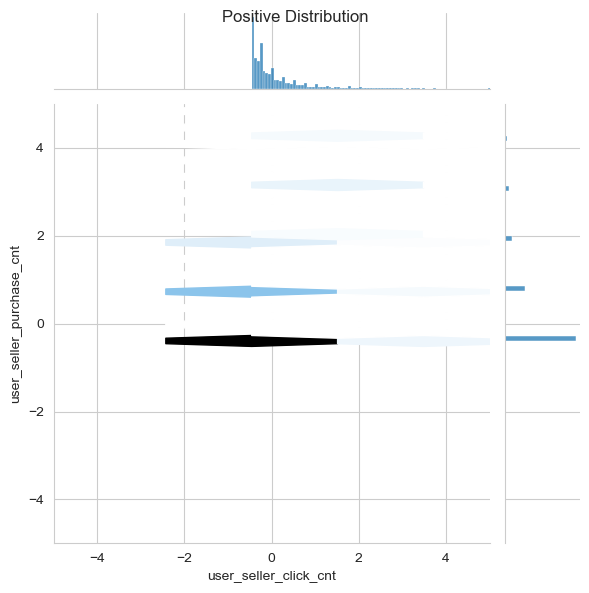

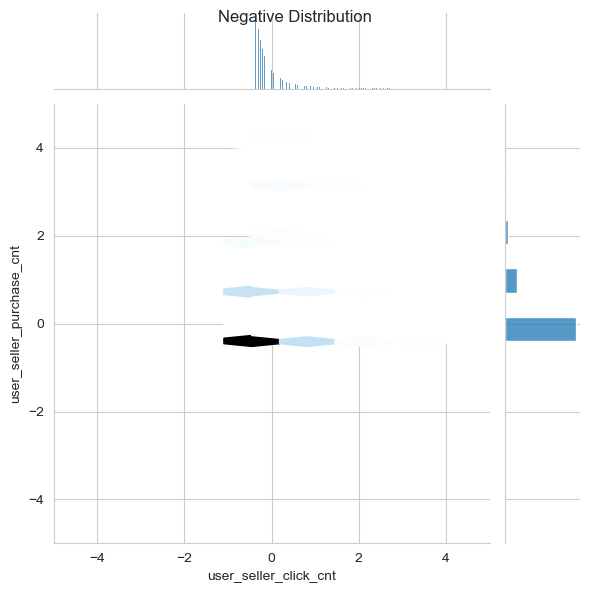

In [312]:
sns.jointplot(data = pos_df,x=pos_df['user_seller_click_cnt'], y=pos_df['user_seller_purchase_cnt'], xlim=(-5,5), ylim=(-5,5), kind = 'hex')
plt.suptitle('Positive Distribution')

sns.jointplot(data = neg_df,x=neg_df['user_seller_click_cnt'], y=neg_df['user_seller_purchase_cnt'], xlim=(-5,5), ylim=(-5,5), kind = 'hex')
plt.suptitle('Negative Distribution')

#### Define Metrics for the Model

In [259]:
Metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

#### Build Model using Keras.

In [260]:
def model_build(metrics=Metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(75, activation='relu', input_shape= (train_x.shape[-1],)),
                             keras.layers.Dropout(0.5),
                             keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])
    model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3),
                 loss= keras.losses.BinaryCrossentropy(),
                  metrics = metrics)
    
    return model


In [261]:
EPOCHS = 100
BATCH_SIZE = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                 verbose=1,
                                                 patience=10,
                                                 mode='max',
                                                 restore_best_weights=True)

model_initial = model_build()
model_initial.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75)                525       
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


#### Predict using the Built Model.

In [262]:
model_initial.predict(train_x)

2024-07-10 14:55:00.093488: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5707/5707 [==============================] - 1s 207us/step


array([[0.56350213],
       [0.56350213],
       [0.5712959 ],
       ...,
       [0.56350213],
       [0.5929347 ],
       [0.51751673]], dtype=float32)

#### Evaluate the Data.

In [263]:
results = model_initial.evaluate(train_x, train_y, batch_size = BATCH_SIZE, verbose=0)
print('Loss:{:0.4f}'.format(results[0]))

Loss:0.7812


#### Set Bias and Predict.

In [264]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.73131475])

In [265]:
model_fix_bias = model_build(output_bias = initial_bias)
model_fix_bias.predict(train_x)

5707/5707 [==============================] - 1s 204us/step


array([[0.05284915],
       [0.05284915],
       [0.05612589],
       ...,
       [0.05284915],
       [0.06361131],
       [0.05028705]], dtype=float32)

#### Evaluate the Data.

In [266]:
results = model_fix_bias.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.2313


In [267]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_fix_bias.save_weights(initial_weights)
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_Y = encoder.transform(train_y)
encoder.fit(test_y)
encoded_Y2 = encoder.transform(test_y)

In [268]:
model_zero_bias = model_build()
model_zero_bias.load_weights(initial_weights)
model_zero_bias.layers[-1].bias.assign([0.0])
with tf.device('cpu:0'):
    zero_bias_history = model_zero_bias.fit(train_x, encoded_Y, batch_size = BATCH_SIZE, epochs=20, validation_data=(test_x, encoded_Y2), verbose=0)

In [269]:
model_bias = model_build()
model_bias.load_weights(initial_weights)
with tf.device('cpu:0'):
    careful_bias = model_bias.fit(train_x, encoded_Y, batch_size = BATCH_SIZE, epochs=20, validation_data=(test_x, encoded_Y2), verbose=0)


In [270]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Define Plot Loss

In [271]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch Count')
    plt.ylabel('Loss')
    
    plt.legend()


#### Plot for Zero Bias and Careful Bias

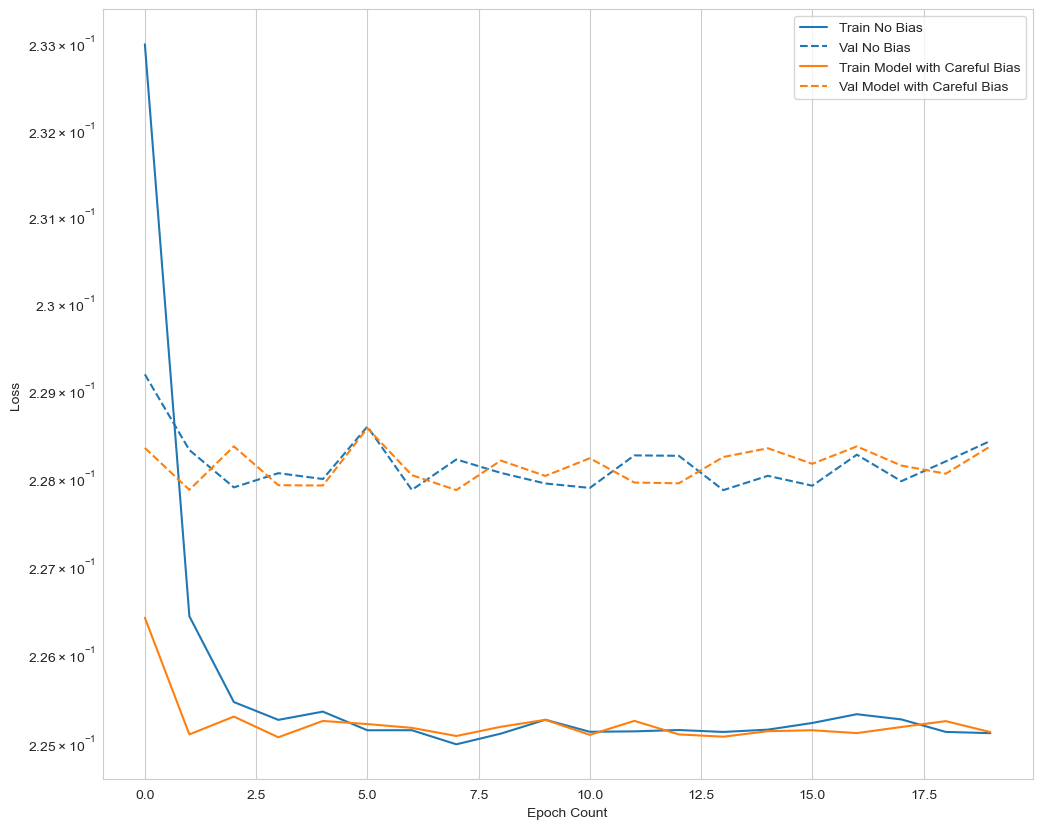

In [272]:
plot_loss(zero_bias_history, 'No Bias', 0)
plot_loss(careful_bias, 'Model with Careful Bias', 1)

#### Train the Model.

In [273]:
#model training
model = model_build()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
baseline_history = model.fit(
    train_x,
    encoded_Y,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(test_x, encoded_Y2))

Epoch 1/100
18261/18261 [==============================] - 10s 538us/step - loss: 0.2329 - accuracy: 0.9386 - precision: 0.1413 - recall: 8.1494e-04 - auc: 0.5763 - val_loss: 0.2282 - val_accuracy: 0.9381 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5967
Epoch 2/100
18261/18261 [==============================] - 10s 527us/step - loss: 0.2265 - accuracy: 0.9391 - precision: 0.1429 - recall: 9.0017e-05 - auc: 0.5908 - val_loss: 0.2290 - val_accuracy: 0.9381 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5992
Epoch 3/100
18261/18261 [==============================] - 10s 528us/step - loss: 0.2257 - accuracy: 0.9391 - precision: 0.3125 - recall: 4.5009e-04 - auc: 0.5957 - val_loss: 0.2284 - val_accuracy: 0.9381 - val_precision: 0.3333 - val_recall: 2.0648e-04 - val_auc: 0.5987
Epoch 4/100
18261/18261 [==============================] - 10s 532us/step - loss: 0.2252 - accuracy: 0.9391 - precision: 0.3636 - recall: 7.2014e-04 - auc: 0.5999 - val_loss: 0

#### Define Plot for the Metrics.

In [274]:
def plot_metrics(history):
    metrics= ['loss','auc','precision','recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('_',' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train Data')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric=='loss':
            plt.ylim([0.2, 0.25])
        elif metric=='auc':
            plt.ylim([0.6, 0.7])
        elif metric=='recall':
            plt.ylim([0, 0.02])
        else:
            plt.ylim([0,1])
        
        plt.legend()

#### Plot Metrics for the Initial Model.

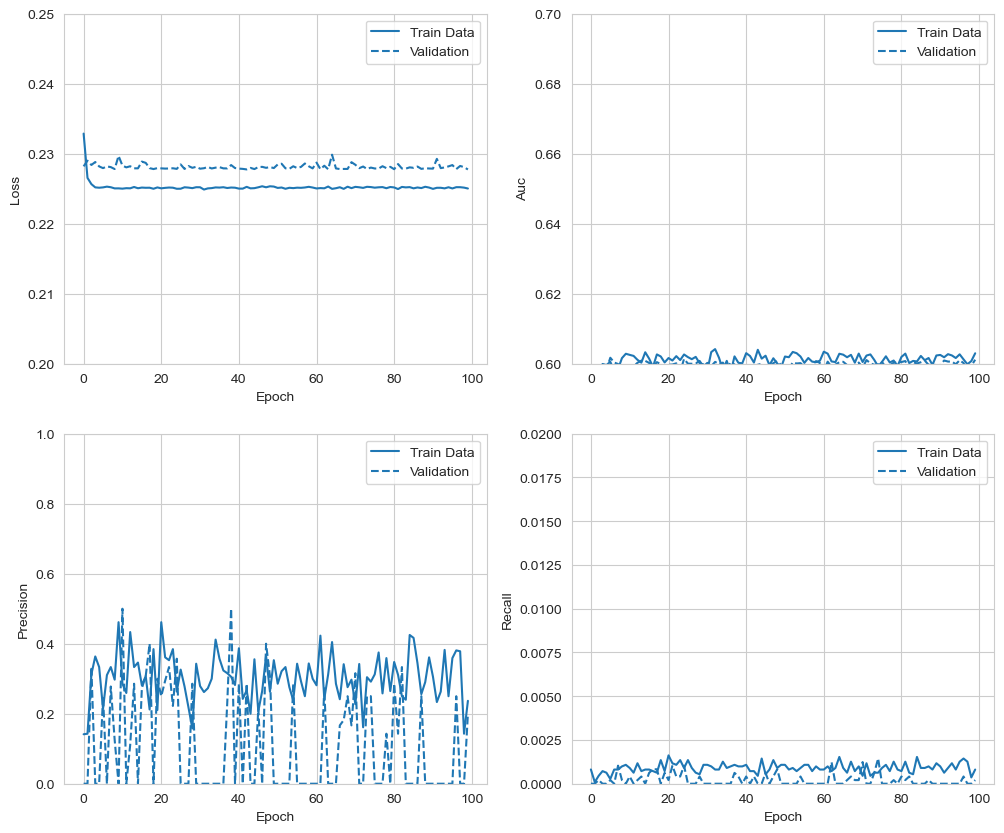

In [275]:
plot_metrics(baseline_history)

#### Predict the Data from Base Model.

In [276]:
train_pred_baseline = model.predict(train_x, batch_size=BATCH_SIZE)
test_pred_baseline = model.predict(test_x, batch_size=BATCH_SIZE)

7826/7826 [==============================] - 2s 224us/step


#### Define Plot for the Confusion Matrix

In [277]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('True Non-Repeat customers Detected (True Negatives): ', cm[0][0])
    print('Non-repeat customers Incorrectly Detected (False Positives): ', cm[0][1])
    print('repeat customers Missed (False Negatives): ', cm[1][0])
    print('repeat customers Detected (True Positives): ', cm[1][1])
    print('Total repeat customers ', np.sum(cm[1]))

#### Evaluate with the New Encoded Data.

In [278]:
baseline_results = model.evaluate(test_x, encoded_Y2, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.22775304317474365
accuracy :  0.9380782246589661
precision :  0.20000000298023224
recall :  0.00020648358622565866
auc :  0.6011418700218201



#### Plot Confusion Matrix of the Predictions.

True Non-Repeat customers Detected (True Negatives):  73413
Non-repeat customers Incorrectly Detected (False Positives):  4
repeat customers Missed (False Negatives):  4842
repeat customers Detected (True Positives):  1
Total repeat customers  4843


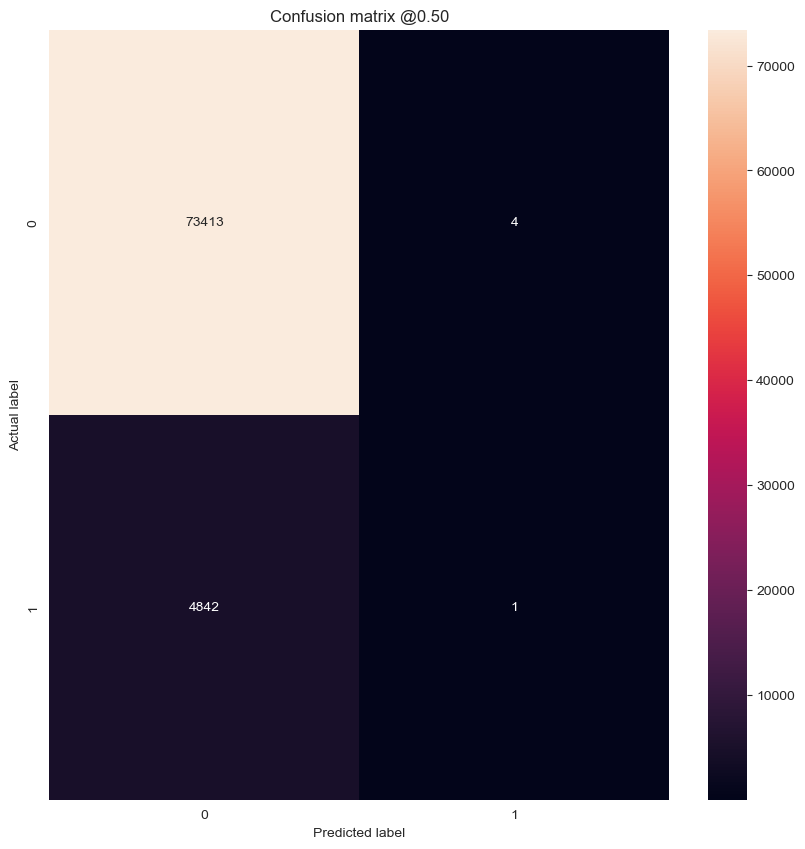

In [279]:
plot_cm(encoded_Y2, test_pred_baseline)

#### Data OverSampling with SMOTE.

In [280]:
#Oversampling with smote
sm = SMOTE()

#### Fit the Training Data.

In [281]:
training_set_x.fillna(training_set_x.mean(), inplace=True)
training_x_sm, training_y_sm = sm.fit_resample(training_set_x, training_set_y)
train_x_sm = training_x_sm.values
train_y_sm = training_y_sm.values
test_x = testing_set_x.values
test_y = testing_set_y.values

#### Scale the Data using StandardScaler() and Fit the Data.

In [282]:
scaler = StandardScaler()
train_x_sm = scaler.fit_transform(train_x_sm)
test_x = scaler.fit_transform(test_x)

#### Label Encoding and Fit the Data.

In [283]:
encoder = LabelEncoder()
encoder.fit(train_y_sm)
encoded_Y_sm = encoder.transform(train_y_sm)
encoder.fit(test_y)
encoded_Y2_sm = encoder.transform(test_y)

In [284]:
train_x_sm

array([[-0.37371021, -0.09853641, -0.45784146, -0.269943  , -0.39533845,
         0.78890858],
       [-0.37371021, -0.09853641, -0.45784146, -0.269943  , -0.39533845,
         0.78890858],
       [-0.33912202, -0.09853641, -0.45784146, -0.269943  , -0.36185454,
         0.17834776],
       ...,
       [-0.30453382, -0.09853641,  0.54131258, -0.269943  , -0.29488673,
         0.42257209],
       [-0.33912202, -0.09853641,  0.54131258, -0.269943  , -0.32837063,
         0.78890858],
       [-0.30453382, -0.09853641, -0.45784146, -0.269943  , -0.32837063,
        -0.12693265]])

In [285]:
train_y_sm

array([0, 0, 0, ..., 1, 1, 1])

In [286]:
test_x

array([[-1.52633516e-03, -1.12877981e-01, -3.96438788e-01,
        -2.66898609e-01, -4.40394748e-02, -7.25371560e-01],
       [-2.38885480e-01, -1.12877981e-01,  7.70979166e-01,
        -2.66898609e-01, -2.13100249e-01, -4.91447254e-02],
       [-5.35584410e-01, -1.12877981e-01, -3.96438788e-01,
         4.13541993e-01, -4.94868206e-01,  7.31117007e-01],
       ...,
       [ 1.83800703e+00,  4.60352930e+00, -3.96438788e-01,
        -2.66898609e-01,  1.75927545e+00, -1.00279795e+00],
       [-3.57565052e-01, -1.12877981e-01, -3.96438788e-01,
        -2.66898609e-01, -3.82161023e-01, -1.79188347e-01],
       [-2.98225266e-01, -1.12877981e-01,  1.93839712e+00,
         4.13541993e-01, -1.56746658e-01,  2.75964330e-01]])

#### Mean of the Train Data after Scaling.

In [287]:
train_y_sm.mean()

0.5

#### Sum of the Train Data after Scaling.

In [288]:
train_y_sm.sum()

171495

#### Define resample_steps

In [289]:
resample_steps_per_epoch = np.ceil((2.0*171495)/10)

In [292]:
resample_steps_per_epoch

34299.0

In [293]:
resample_model = model_build()
resample_model.load_weights(initial_weights)

output_layer = resample_model.layers[-1]
output_layer.bias.assign([0])

resample_history = resample_model.fit(
    train_x_sm,
    encoded_Y_sm,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(test_x, encoded_Y2_sm))


Epoch 1/100
34299/34299 [==============================] - 17s 480us/step - loss: 0.6754 - accuracy: 0.5841 - precision: 0.6036 - recall: 0.4906 - auc: 0.6079 - val_loss: 0.6927 - val_accuracy: 0.6186 - val_precision: 0.0852 - val_recall: 0.5305 - val_auc: 0.6005
Epoch 2/100
34299/34299 [==============================] - 16s 465us/step - loss: 0.6741 - accuracy: 0.5845 - precision: 0.6022 - recall: 0.4978 - auc: 0.6071 - val_loss: 0.7543 - val_accuracy: 0.6024 - val_precision: 0.0844 - val_recall: 0.5511 - val_auc: 0.6010
Epoch 3/100
34299/34299 [==============================] - 16s 466us/step - loss: 0.6743 - accuracy: 0.5850 - precision: 0.6029 - recall: 0.4980 - auc: 0.6068 - val_loss: 0.6983 - val_accuracy: 0.6048 - val_precision: 0.0845 - val_recall: 0.5476 - val_auc: 0.6002
Epoch 4/100
34299/34299 [==============================] - 16s 468us/step - loss: 0.6743 - accuracy: 0.5851 - precision: 0.6021 - recall: 0.5018 - auc: 0.6066 - val_loss: 0.6634 - val_accuracy: 0.6408 - val_p

#### Define Metrics Plot for the Model.

In [294]:
def plot_metrics(history):
    metrics= ['loss','auc','precision','recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('_',' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train Data')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric=='loss':
            plt.ylim([0, 1])
        elif metric=='auc':
            plt.ylim([0.4, 1])
        elif metric=='recall':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])
        
        plt.legend()

#### Plot Metrics for the initial Model.

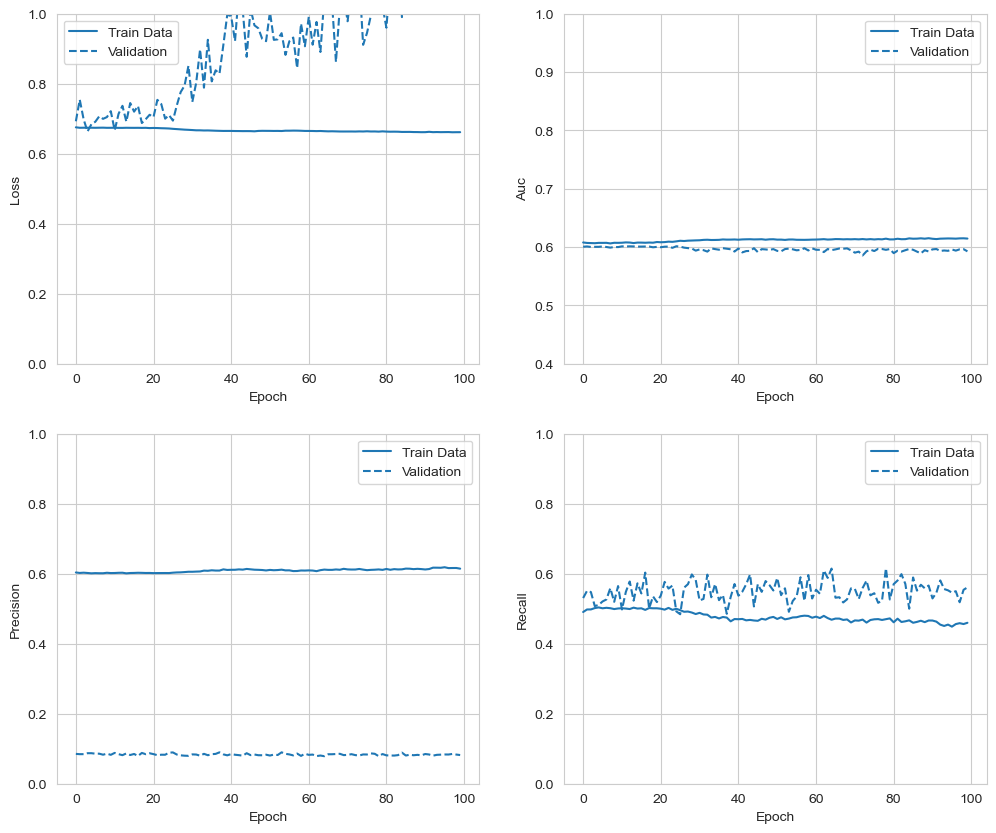

In [295]:
plot_metrics(resample_history)

#### Rebuild the Model.

In [296]:
resample_model = model_build()
resample_model.load_weights(initial_weights)

output_layer = resample_model.layers[-1]
output_layer.bias.assign([0])

resample_history = resample_model.fit(
    train_x_sm,
    encoded_Y_sm,
    epochs=EPOCHS, 
    validation_data=(test_x, encoded_Y2_sm))


Epoch 1/100
10719/10719 [==============================] - 6s 520us/step - loss: 0.6754 - accuracy: 0.5830 - precision: 0.5019 - recall: 0.4953 - auc: 0.5986 - val_loss: 0.7286 - val_accuracy: 0.5967 - val_precision: 0.0839 - val_recall: 0.5561 - val_auc: 0.6010
Epoch 2/100
10719/10719 [==============================] - 5s 510us/step - loss: 0.6738 - accuracy: 0.5849 - precision: 0.6029 - recall: 0.4971 - auc: 0.6075 - val_loss: 0.7276 - val_accuracy: 0.6091 - val_precision: 0.0850 - val_recall: 0.5443 - val_auc: 0.6011
Epoch 3/100
10719/10719 [==============================] - 5s 511us/step - loss: 0.6735 - accuracy: 0.5856 - precision: 0.6042 - recall: 0.4966 - auc: 0.6081 - val_loss: 0.7061 - val_accuracy: 0.6226 - val_precision: 0.0856 - val_recall: 0.5265 - val_auc: 0.6009
Epoch 4/100
10719/10719 [==============================] - 5s 510us/step - loss: 0.6736 - accuracy: 0.5853 - precision: 0.6049 - recall: 0.4919 - auc: 0.6073 - val_loss: 0.7229 - val_accuracy: 0.6072 - val_preci

#### Plot the Metrics for the Model.

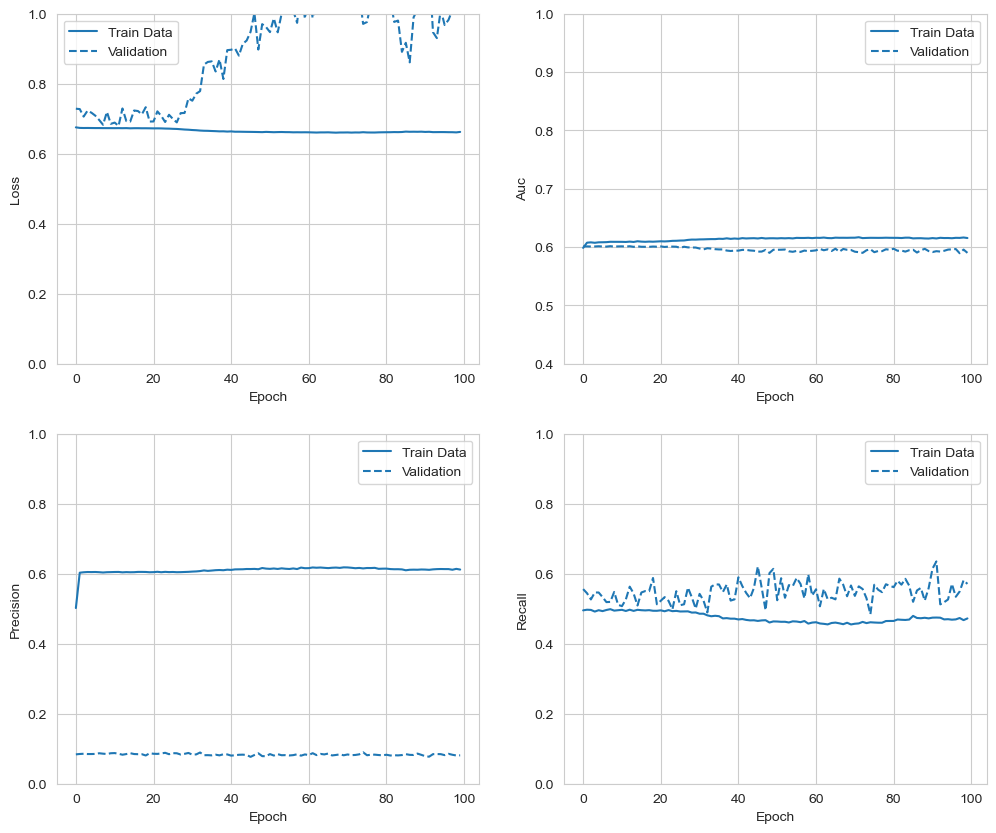

In [297]:
plot_metrics(resample_history)

#### Predict the Train and Test Data.

In [298]:
train_prediction_resample = resample_model.predict(train_x, batch_size=BATCH_SIZE)
test_prediction_resample = resample_model.predict(test_x, batch_size=BATCH_SIZE)

7826/7826 [==============================] - 2s 223us/step


#### Evaluate and lot the Confusion Matrix.

loss : 1.1021546125411987
accuracy : 0.5731024742126465
precision : 0.08109455555677414
recall : 0.570927083492279
auc : 0.5900602340698242

True Non-Repeat customers Detected (True Negatives):  42086
Non-repeat customers Incorrectly Detected (False Positives):  31331
repeat customers Missed (False Negatives):  2078
repeat customers Detected (True Positives):  2765
Total repeat customers  4843


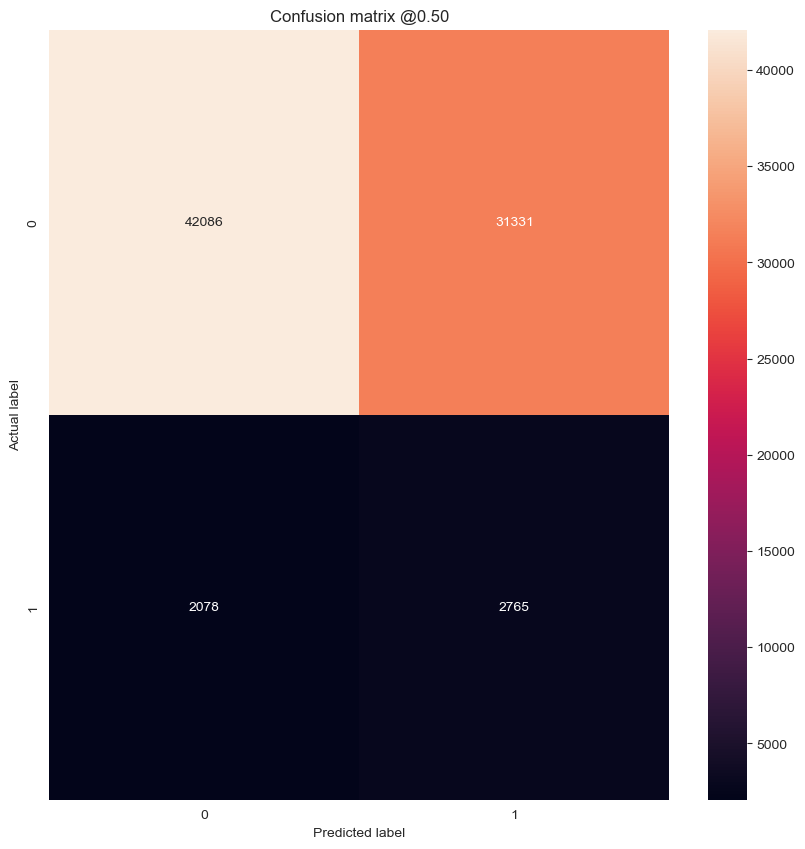

In [299]:
resampled_results = resample_model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resample_model.metrics_names, resampled_results):
    print(name, ':', value)
print()

plot_cm(test_y, test_prediction_resample)

In [300]:
test_prediction_resample

array([[0.49882352],
       [0.81043905],
       [0.53097004],
       ...,
       [0.4412063 ],
       [0.39218768],
       [0.99111116]], dtype=float32)

In [301]:
test.head()

,user_id,seller_id,prob,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,163968,4605,NaN,1,0,1,0,2,0.500000
1,360576,1581,NaN,5,0,5,0,10,0.500000
2,98688,1964,NaN,5,0,1,0,6,0.166667
3,98688,3645,NaN,10,0,1,0,11,0.090909
4,295296,3361,NaN,47,0,1,2,50,0.020000


#### Load the Test Data.

In [302]:
test_x_id = test[['user_id','seller_id']]
test_x = test.drop(['user_id','seller_id'], axis=1)

In [303]:
test_x_id.head()

,user_id,seller_id
0,163968,4605
1,360576,1581
2,98688,1964
3,98688,3645
4,295296,3361


In [304]:
test_x.head()

,prob,user_seller_click_cnt,user_seller_add_to_cart_cnt,user_seller_purchase_cnt,user_seller_add_to_favorite_cnt,user_seller_action_total_cnt,user_seller_purchase_rt
0,NaN,1,0,1,0,2,0.500000
1,NaN,5,0,5,0,10,0.500000
2,NaN,5,0,1,0,6,0.166667
3,NaN,10,0,1,0,11,0.090909
4,NaN,47,0,1,2,50,0.020000


#### Get Test DataSet and Scale the Data.

In [305]:
test_x = test_x.drop(['prob'], axis=1)
test_x = test_x.values
scaler = StandardScaler()
test_x = scaler.fit_transform(test_x)

#### Predict the Probability.

In [306]:
final_prediction = resample_model.predict(test_x, batch_size=BATCH_SIZE)
final_prediction

26148/26148 [==============================] - 5s 207us/step


array([[0.38033324],
       [0.99873525],
       [0.44072717],
       ...,
       [0.991474  ],
       [0.3840288 ],
       [0.5067408 ]], dtype=float32)

#### Get the Data into a DataFrame.

In [307]:
final_submission = pd.DataFrame(final_prediction, columns=['Prob'])
final_output_dl = pd.concat([test_x_id.reset_index(drop=True), final_submission.reset_index(drop=True)], axis=1)

In [308]:
final_output_dl.head()

,user_id,seller_id,Prob
0,163968,4605,0.380333
1,360576,1581,0.998735
2,98688,1964,0.440727
3,98688,3645,0.506741
4,295296,3361,0.528573


#### Write the Final Probability to a File.

In [309]:
final_output_dl.to_csv('Final_Probability_Prediction.csv', index=False)